# Data Preprocessing: Constructing Meaningful Acoustic Representations

In this notebook, we will be using the Orchive dataset, which we have uploaded to and stored in a Google API bucket [here](https://storage.googleapis.com/ml-bioacoustics-datasets/orchive-dataset.tar.gz). For this data preprocessing phase, we will explore different options for representing the acoustic signals. Let's get started with loading the data.

## Loading the Data

We'll begin with a few usual imports, and we'll employ fastai's ``untar_data`` method to access the Orchive dataset.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import soundfile as sf
from IPython.display import Audio

from fastai2.vision.all import *

np.random.seed(42)

In [4]:
path = untar_data('https://storage.googleapis.com/ml-bioacoustics-datasets/orchive-dataset.tar.gz')

In [5]:
path.ls()

(#10) [Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/._call-catalog'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/audible'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/._.DS_Store'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog-xsilence'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/._extract'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/.DS_Store'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/._call-catalog-xsilence'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/._audible'),Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/extract')]

Great! We've loaded the path and confirmed that it contains the appropriate directories. Next, we'll dive into the directory 'call-catalog-xsilence', which contains signals that have been processed to remove leading and tailing silences, allowing us to focus expressly on the call type contained in the sample. Furthermore, for this initial data_preprocessing, let's take a look at a single call type. For simplicity, we'll look at a N01 call.

In [6]:
call_path = Path.home() / '.fastai/data/orchive-dataset/call-catalog-xsilence/N01'
file_path = call_path.ls()[0]
file_path

Path('/home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff')

Ok, now that we've extracted a single path to a single .aiff file, let's inspect this file. We can start off by defining a ``Labelling`` class to generate a suite of labels for the signal.

In [7]:
class Labelling(object):
    
    def __init__(self, path):
        self.path=path
        
    def get_path_name(self):
        return str(self.path)
    
    def get_aiff_name(self):
        path_name = self.get_path_name()
        return path_name.split('/')[-1]
    
    def gen_label(self):
        aiff_name = self.get_aiff_name()
        label = aiff_name.split('-')[0] + '-' + aiff_name.split('-')[1]
        return label
    
    def get_matriline(self):
        label = self.gen_label()
        return label.split('-')[0]
    
    def get_call_type(self):
        label = self.gen_label()
        return label.split('-')[1]
        
    
labeller = Labelling(file_path)
print(f'Original Path: {labeller.get_path_name()}')
print(f'File Name: {labeller.get_aiff_name()}')
print(f'Signal Label: {labeller.gen_label()}')
print(f'Matriline: {labeller.get_matriline()}')
print(f'Call Type: {labeller.get_call_type()}')

Original Path: /home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff
File Name: A36-N01-062802-D004-12218.aiff
Signal Label: A36-N01
Matriline: A36
Call Type: N01


As shown using the above print statements, the ``Labelling`` class contains objects to get the path to the .aiff file, the name of the .aiff file, the appropropriate label for the signal, and the matriline and call type of the signal. Now that we have labels, let's inspect the audio. Firstly, it's often helpful to hear the audio so that we can build a connection to the animals we are working with! Let's hear what an N01 call sounds like.

In [8]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)
Audio(data, rate=sample_rate)

Wow! How cool is that?! When working with bioacoustic data, it's always important to remember that the computational we develop can help us develop better conservation and management strategies in order to protect these incredible animals!

## Representations of the Signal

When carrying out audio signal processing using acoustic data, there is an extensive array of options for exploring various representations of the signal. For example, common representations include the naive time space representation, the Fourier transformed frequency space representation, as well as an FFT spectrogram-based time-frequency space representation, but there are many other possibilities in addition to more nuanced possibilities *within* these common representations. Let's start off with the straightforward time-space and frequency-space representations.

### Time and Frequency Space Representations

Here, we will plot the original signal in both the time and frequency domains. To carry out the Fourier transform, we will use the ``fft`` method in the ``scipy.fft`` module. Here, we are employing a mathematical technique called a discrete Fourier transform (DFT) to convert from the time domain to the frequency domain, and we make use of the fast Fourier transform (FFT) algorithm to compute the transform quickly and efficiently.

In [9]:
from scipy.fft import fft

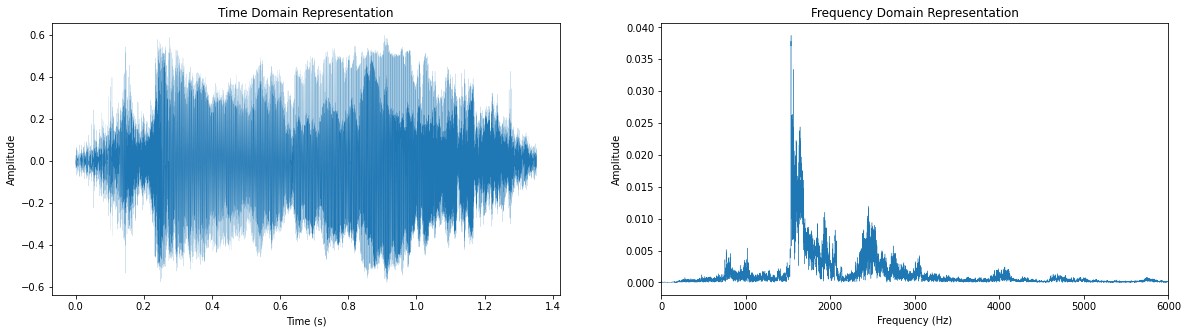

In [10]:
def plot_t_and_f_reps(signal, fs):
    N = len(signal)
    delta_t = 1 / fs
    times = np.arange(0, N) / fs
    signalf = fft(signal)
    freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(times, signal, linewidth=0.1)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Time Domain Representation')
    
    axs[1].plot(freqs, 2.0/N * np.abs(signalf[0:N//2]), linewidth=0.4)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('Frequency Domain Representation')
    axs[1].set_xlim([0, 6e3])
    
plot_t_and_f_reps(data, sample_rate)

### Spectrogram Time-Frequency Space Representation

Visually, the above representations immediately seem inadequate. It's challengning to extract any meaningful information purely from the time-varying amplitude, and the frequency space representation entirely omits temporal information. With that in mind, we turn our attention towards the spectrogram, which offers a time-frequency space representation of a signal.

The process of generating a spectrogram requires splitting the signal into overlapping segments and applying the Fourier transform to these windows. This is called the short time Fourier transform (STFT).

The following plot presents a spectrogram representation of our orca call. We'll start off using the ``spectrogram`` method found in ``scipy.signal``.

In [11]:
from scipy.signal import spectrogram

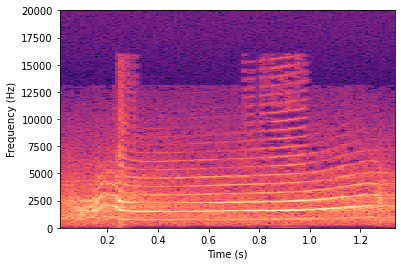

In [12]:
f_bins, t_bins, Sxx = spectrogram(data, fs=sample_rate,
                                 window='hanning', nperseg=1024,
                                 noverlap=1024-512, detrend=False,
                                 scaling='spectrum')
plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 2e4])
plt.show()

Awesome! We now have a time-frequency representation of our signal. Note that we take the log of ``Sxx`` to compress the spectrum to the dB scale. More on this later.

However, there are many parameters to consider when constructing spectrograms. To begin unpacking the numerous options, we start by considering the uncertainty principle, which tells us that there is a tradeoff between time resolution and frequency resolution, since we can't simultaneously minimize both. The parameter ``nperseg`` yields insights into these resolutions. 

Using ``nperseg=1024`` with a sample rate of 44.1 kHz leads to a window length (temporal resolution) of 

$$ \frac{1024}{44100} = 0.023 \text{s} $$

and a frequency resolution of 

$$ \frac{44100}{1024} = 43.1 \text{Hz}$$

This tells us that all else equal, increasing ``nperseg`` improves frequency resolution but impairs temporal resolution. This is demonstrated in the following plot.

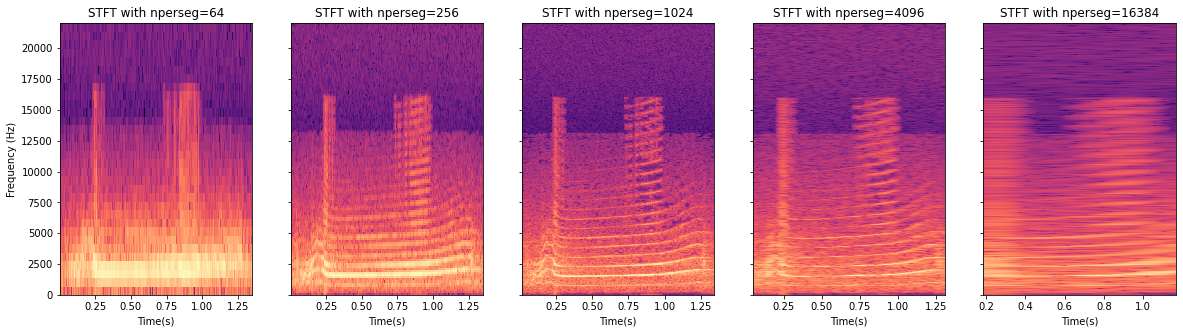

In [13]:
npersegs = [64, 256, 1024, 4096, 16384]
fig, axs = plt.subplots(1, len(npersegs), sharey=True, figsize=(20,5))
axs[0].set_ylabel('Frequency (Hz)')

for i, window_length in enumerate(npersegs):
    f_bins, t_bins, Sxx = spectrogram(data, fs=sample_rate,
                                 window='hanning', nperseg=window_length,
                                 noverlap=window_length-64, detrend=False,
                                 scaling='spectrum')
    axs[i].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
    axs[i].set_xlabel('Time(s)')
    axs[i].set_title(f'STFT with nperseg={window_length}')

In general, it is a safe bet to use ``noverlap = nperseg // 2``, but this can depend on the choice of window. Now that we have a better understanding of the window length parameter used in generating spectrograms, let's proceed with the windowing function. Again, we have many options here. A great place to start is the Kaiser window, defined mathematically by

$$w(n) = I_0 \Bigg( \beta\sqrt{1-\frac{4n^2}{(M-1)^2}}\Bigg) / I_0(\beta) \hspace{2mm}\text{for} -\frac{M-1}{2} \leq n \leq \frac{M-1}{2}$$

In general, a safe choice for $\beta$ is 14, but the following approximations are also used:

* $\beta$=0: Recrangular
* $\beta$=5: Hamming
* $\beta$=6: Hann
* $\beta$=8.6: Blackman

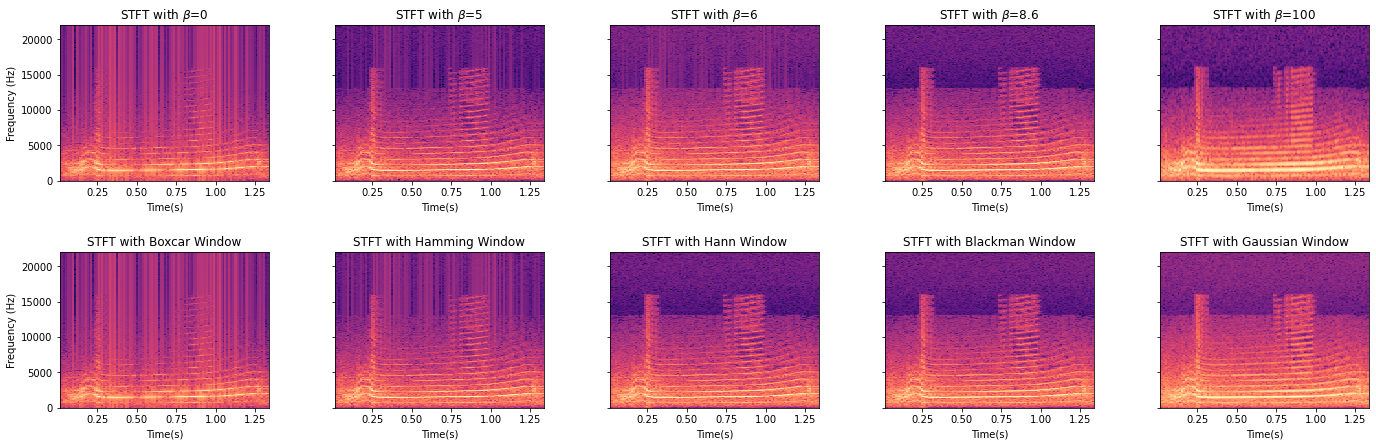

In [14]:
from scipy.signal import kaiser, gaussian
betas = [0, 5, 6, 8.6, 100]
win_g = gaussian(1024, 100)
wins = ['boxcar', 'hamming', 'hann', 'blackman', win_g]
fig, axs = plt.subplots(2, len(betas), sharey=True, figsize=(20,7))
fig.tight_layout(pad=5.0)
axs[0, 0].set_ylabel('Frequency (Hz)')
axs[1, 0].set_ylabel('Frequency (Hz)')
for i in range(2):
    if i == 0:
        for j, B in enumerate(betas):
            win = kaiser(1024, beta=B)
            f_bins, t_bins, Sxx = spectrogram(data, fs=sample_rate,
                                         window=win, nperseg=1024,
                                         noverlap=512, detrend=False,
                                         scaling='spectrum')
            axs[0,j].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
            axs[0,j].set_xlabel('Time(s)')
            axs[0,j].set_title(fr'STFT with $\beta$={B}')
    elif i ==1:
        for j, win in enumerate(wins):
            f_bins, t_bins, Sxx = spectrogram(data, fs=sample_rate,
                                         window=win, nperseg=1024,
                                         noverlap=512, detrend=False,
                                         scaling='spectrum')
            axs[1,j].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
            axs[1,j].set_xlabel('Time(s)')
            if j < 4:
                axs[1,j].set_title(f'STFT with {win.capitalize()} Window')
            elif j ==4:
                axs[1,j].set_title(f'STFT with Gaussian Window')  

We clearly see different behaviors depending on the choice of window. How do we make sense of this? A good resource to use can be accessed [here](https://www.ni.com/en-us/innovations/white-papers/06/understanding-ffts-and-windowing.html). 

You might be wondering why we need a window in the first place. In general, performing an FFT over a noninteger number of cycles can introduce spectral leakage due to artificial discontinuites present when segmenting the original signal into discrete windows. Applying a window reduces the amplitude of the discontinuities at the boundaries of each finite segment of the signal, minimizing the degree of spectral leakage.

Now that we understand the motivation for windowing, how do we choose an appropriate window for our given application?

#### Choosing a Window

In general, the Fourier transform of a window yields a spectrum with a main lobe and side lobes of decaying amplitude. Lower side lobes typically minimize spectral leakage, but they also increase the bandwidth of the major lobe. The decay rate of the side lobe peaks is commonly referred to as the 'side lobe roll-off rate'.

With this in mind, selecting a window involves estimating the frequency content of the original signal. Important considerations include the distance (in frequency space) of strong interfering frequency components, the broadband/narrowband nature of a signal, and the desired amplitude accuracy of frequency components, among others.

A Hann window is often a satisfactoy choice for the majority of applications. There is no *a priori* approach to selecting a window from first principles, but the following can help you make an informed decision:

* Rectangular: transients with durations shorter than the window length, two tones with frequencies close to each other with similar amplitudes
* Exponential: transients with durations longer than the window length, response signals
* Hanning: transients with durations longer than the window length, general-purpose applications, sine wave or combination of sine waves, narrowband random signal, unknown content
* Kaiser: two tones with frequencies close to each other with widely differing amplitudes
* Flat top: sine waves with emphasis on amplitude accuracy

Before moving on, let's take a look at a transient, broadband signal, such as a sperm whale click.

In [15]:
data_path = '/home/radek/workspace/sperm_whale/data'
annos = '/home/radek/workspace/sperm_whale/annotations/all_codas_with_frames.csv'
annos_df = pd.read_csv(annos)
annos_df.head()

codaNUM2018            REC  nClicks  Duration      ICI1      ICI2  \
0         4931  sw061b001_124       17  0.927792  0.033950  0.036117   
1         4932  sw061b001_124       20  1.092992  0.032817  0.039358   
2         4933  sw061b001_124        5  0.898250  0.275850  0.286783   
3         4934  sw061b001_124        5  0.865575  0.262275  0.276883   
4         4935  sw061b001_124        5  0.858317  0.266675  0.269358   

       ICI3      ICI4      ICI5      ICI6  ...  IPI37  IPI38  IPI39  IPI40  \
0  0.048867  0.048908  0.042275  0.040483  ...    0.0    0.0    0.0    0.0   
1  0.045325  0.049933  0.044083  0.044783  ...    0.0    0.0    0.0    0.0   
2  0.197400  0.138217  0.000000  0.000000  ...    0.0    0.0    0.0    0.0   
3  0.183333  0.143083  0.000000  0.000000  ...    0.0    0.0    0.0    0.0   
4  0.178325  0.143958  0.000000  0.000000  ...    0.0    0.0    0.0    0.0   

   start_time                path  sample_rate       filename  start_frame  \
0    126.0372  2015/sw061b001.wav       120000  sw061b001.wav     15124464   
1    128.3256  2015/sw061b001.wav       120000  sw061b001.wav     15399072   
2    131.7476  2015/sw061b001.wav       120000  sw061b001.wav     15809712   
3    135.5877  2015/sw061b001.wav       120000  sw061b001.wav     16270524   
4    139.5217  2015/sw061b001.wav       120000  sw061b001.wav     16742604   

   duration_in_frames  
0              111334  
1              131159  
2              107790  
3              103869  
4              102997  

[5 rows x 104 columns]

In [16]:
def extract_click(row):
    raw_audio_path = data_path + '/' + row.path
    start_frame = row.start_frame + int(row.ICI1*row.sample_rate/2)
    duration = int(row.ICI1*row.sample_rate/2) + int(row.ICI2*row.sample_rate/2)
    waveform, sample_rate = sf.read(raw_audio_path, start=start_frame, frames=duration)
    return waveform, sample_rate

Let's see what this looks like in the time domain:

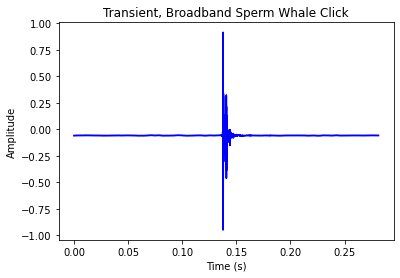

In [17]:
x = annos_df.iloc[2]
wf, sr = extract_click(x)
t = np.arange(0, len(wf)) / sr
fig = plt.figure()
plt.plot(t, wf, color='b')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Transient, Broadband Sperm Whale Click')
plt.show()

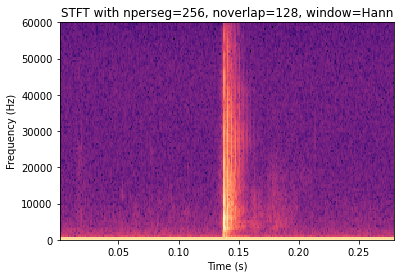

In [18]:
def gen_spectrogram(data, sr, win_length = 256, overlap=128, win='hann'):
    fig = plt.figure()
    f_bins, t_bins, Sxx = spectrogram(data[:,0], fs=sr,
                                             window=win, nperseg=win_length,
                                             noverlap=overlap, detrend=False,
                                             scaling='spectrum')
    
    Sxx[Sxx == 0] = 1e-100
    plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'STFT with nperseg={win_length}, noverlap={overlap}, window={win.capitalize()}')

data = wf
sr = sr
gen_spectrogram(data, sr)

Let's start off by using the ``soundfile`` module to read our wavfile signal. In this case, we'll focus our attention on a single transient broadband sperm whale click. The raw audio file can be found under the 'Best Of' cuts in the [Watkins Marine Mammal Sound Database](https://cis.whoi.edu/science/B/whalesounds/index.cfm).

In [19]:
signal = 'data/WatkinsPMacro.wav'
wf, sr = sf.read(signal)

Let's manually investigate a single click in the recording by first plotting the waveform amplitude in the time domain.

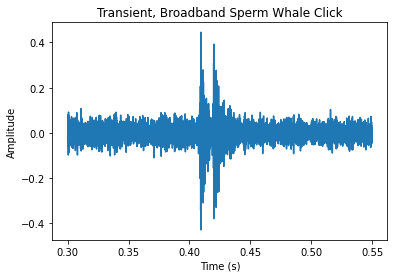

In [20]:
ts = np.arange(0, len(wf))/sr
conds = (ts>0.3) & (ts<0.55)
ts_click = ts[conds]
wf_click = wf[conds]
plt.figure()
plt.plot(ts_click, wf_click)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Transient, Broadband Sperm Whale Click')
plt.show()
Audio(wf, rate=sr)

Awesome! Now let's take a look at the spectrogram, making use of some of the techniques described above.

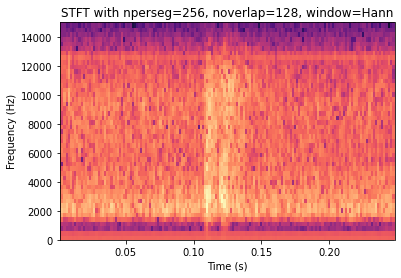

In [21]:
def gen_spectrogram(data, sr, win_length = 256, overlap=128, win='hann'):
    fig = plt.figure()
    f_bins, t_bins, Sxx = spectrogram(data, fs=sr,
                                             window=win, nperseg=win_length,
                                             noverlap=overlap, detrend=False,
                                             scaling='spectrum')
    
    Sxx[Sxx == 0] = 1e-100
    plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim([0, 15000])
    plt.title(f'STFT with nperseg={win_length}, noverlap={overlap}, window={win.capitalize()}')

data = wf_click
sr = sr
gen_spectrogram(data, sr, win_length=256)

This example shows that we can make well-informed decisions in order to construct a high-fidelity representation of an acoustic signal using a spectrogram-based approach. Firstly, we know that we want good temporal resolution (and we are not terribly concerned with frequency resolution of a broadband signal), so choosing ``npserseg=256`` yields a temporal resolution of ~2ms. Then, we select `noverlap = nperseg / 2` and a Hann window, which are good starting points in general. With these choices, we achieve a robust representation of the time-frequency characteristics of the signal of interest.

#### Other Parameters

While the packages for constructing spectrograms often include numerous additional parameters to specify, we emphasize here the window size, overlap, and window type. If ever you need to explore more technical parameters, the Python modules often provide extensive and thorough documentation.

#### Spectrogram Goodness

Now that we have an understanding of how to construct spectrograms, we need a way to determine the "goodness" of a representation in the sense of maximizing the amount of information contained in the original signal. A visual inspection of the above spectrograms clearly indicates that there is a noticeable (though subjective) advantage of some choices of parameters versus others. How can we quantify this in an objective way? We need a metric to compare the goodness of representations.

Here we'll define a function ``spec_rep_goodness`` to do exactly this. The motivation behind the function is to generate a spectrogram that contains the largest number of meaningful dimensions (i.e., features or information) as possible. The procedure will be as follows:

* Construct a SciPy spectrogram with clearly-defined parameter values
* Interpolate the spectrogram to circumvent errors due to frequency and time bin sizes
* Carry out a PCA and calculate the number of features required to meet some threshold for the explained variance ratio
* After carrying out a grid search of parameter values, generate the final spectrogram by maximizing the number of required features.

Our implementation of this is as follows:

In [22]:
from scipy import interpolate
from sklearn.decomposition import PCA
from itertools import count

labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

def spec_rep_goodness(x=data, sr=sample_rate, win='hann', win_length=1024, n_pca=100, th=0.95, vis=True):
    f, t, Sxx = spectrogram(x, fs=sr, window=win, nperseg=win_length,
                            noverlap=win_length//2, detrend=False,
                            scaling='spectrum')
    
    tt, ff = np.meshgrid(t, f)
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(Sxx), kind='cubic')
    
    t_interp = np.linspace(t.min(), t.max(), 1000)
    f_interp = np.linspace(f.min(), f.max(), 1000)
    Sxx_interp = interp_fx(t_interp, f_interp)
    
    if vis:
        fog = plt.figure()
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
    
    pca = PCA(n_components=n_pca)
    pca.fit(Sxx_interp)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

Now that we have our function, let's test it for a few examples by varying ``nperseg``. Given the well-established computational efficiency of using powers of 2 for the window length, we'll proceed with this in consideration.

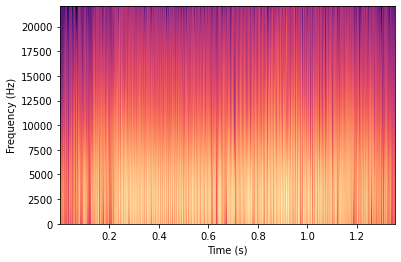

Number of Features to Exceed Threshold th=0.95: 1


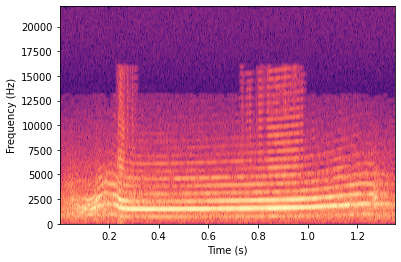

Number of Features to Exceed Threshold th=0.95: 5


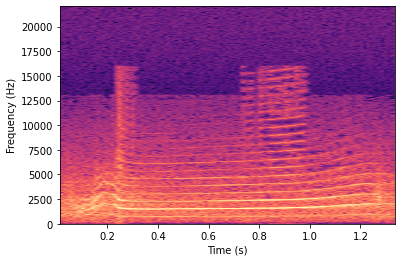

Number of Features to Exceed Threshold th=0.95: 15


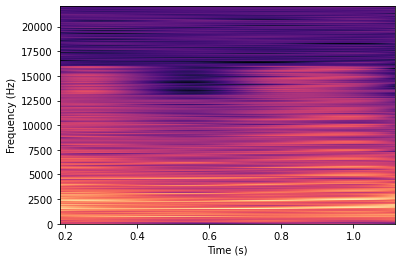

Number of Features to Exceed Threshold th=0.95: 3


In [23]:
ps = [3, 8, 10, 14]
for p in ps:
    spec_rep_goodness(win_length=2**p)

This is looking promising. Let's carry out a grid search of possible ``nperseg`` values:

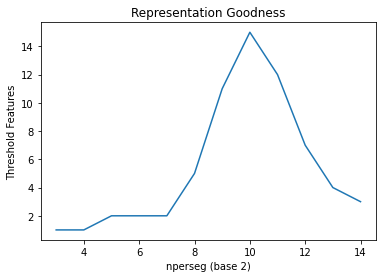

In [22]:
ps = np.arange(3, 15)
th_features = []
for p in ps:
    th_features.append(spec_rep_goodness(win_length=2**p, vis=False))
plt.figure()
plt.plot(ps, th_features)
plt.xlabel('nperseg (base 2)')
plt.ylabel('Threshold Features')
plt.title('Representation Goodness')
plt.show()

This result is fantastic and it agrees with our visual analysis of the spectrograms! Analyzing the plot, we see that for small values of ``nperseg``, we sacrifice too much frequency resolution and thus lose information. Oppositely, for large values of ``nperseg``, we sacrifice too much temporal resolution, again leading to information loss. In the intermediate range, we find a balance where the frequency and temporal resolutions have been optimized to convey as much information as possible. Thus, this tool can be used to ensure that we are not artificially eliminating important information (or dimensionality) by arbitrarily choosing parameter values. This is crucial since we want our neural networks to be able to extract as much meaningful information from the inputs as possible.

An alternative approach involves making use of the Von Neumann entropy, which provides insight into information contained in a matrix. Heavily used in quantum mechanics, this quantity is zero for a pure state and maximal for a maximally mixed state, so it serves somewhat as an information metric. With this in mind, let's define a similar function as above, this time making use of this metric.

In [23]:
from scipy import linalg as la
import math as m
    
def vn_entropy(arr):
    
    eigenvals = la.eigvals(arr)
    eigenvals = np.array([x for x in eigenvals.tolist() if x])

    log2_eigenvals = np.matrix(np.log2(eigenvals))
    eigenvals = np.matrix(eigenvals)

    S = -np.dot(eigenvals, log2_eigenvals.H)
    vn = np.array(np.abs(S)).flatten()
    
    return vn[0]

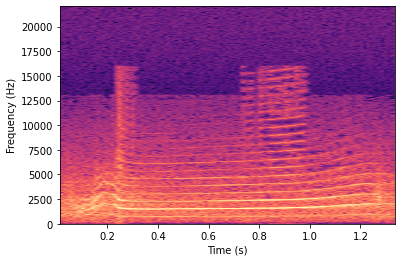

Von Neumann Entropy: 2884811.214045248


2884811.214045248

In [24]:
def spec_rep_goodness_vn(x=data, sr=sample_rate, win='hann', win_length=1024, norm='null', vis=True):
    f, t, Sxx = spectrogram(x, fs=sr, window=win, nperseg=win_length,
                            noverlap=win_length//2, detrend=False,
                            scaling='spectrum')
    
    tt, ff = np.meshgrid(t, f)
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(Sxx), kind='cubic')
    
    t_interp = np.linspace(t.min(), t.max(), 1000)
    f_interp = np.linspace(f.min(), f.max(), 1000)
    Sxx_interp = interp_fx(t_interp, f_interp)
    
    if vis:
        fog = plt.figure()
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
    
    if norm == 'null':
        Sxx_norm = Sxx_interp
    elif norm == 'standardize':
        Sxx_norm = (Sxx_interp - np.mean(Sxx_interp)) / np.std(Sxx_interp)
    elif norm == 'minmax':
        Sxx_norm = (Sxx_interp - np.min(Sxx_interp)) / (np.max(Sxx_interp) - np.min(Sxx_interp))
    
    vn = vn_entropy(Sxx_norm)
    if vis:
        print(f'Von Neumann Entropy: {vn}')
    
    return vn

spec_rep_goodness_vn()

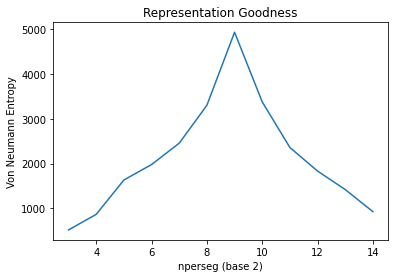

In [25]:
ps = np.arange(3, 15)
vns = []
for p in ps:
    vns.append(spec_rep_goodness_vn(win_length=2**p, norm='standardize', vis=False))
plt.figure()
plt.plot(ps, vns)
plt.xlabel('nperseg (base 2)')
plt.ylabel('Von Neumann Entropy')
plt.title('Representation Goodness')
plt.show()

Interestingly, this approach yields a similar solution as with the PCA-based method, but it's definitely worth exploring both of these ideas more extensively. For now, let's move on and continue developing our representation toolbox.

#### Python Modules

For the above examples, we used SciPy's ``spectrogram`` method to construct our spectrogram. But this is not the only option. For instance, matplotlib and librosa also include methods for carrying out this type of analysis. Let's explore these options. We'll return to the orca signal as we proceed.

In [32]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

We'll quickly start off by constructing a spectrogram using plt.specgram. One nice thing about this method is that it includes interpolation, yielding a more attractive-looking image.

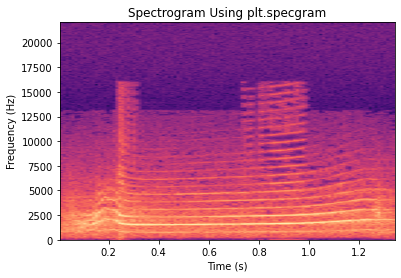

In [33]:
plt.figure()
plt.specgram(data, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='magma')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram Using plt.specgram')
plt.show()

Great! Well that was easy. Let's see what happens when we use different modules:

In [34]:
def interp(spec, freqs, ts):
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(spec), kind='cubic')
    
    ts_interp = np.linspace(t.min(), t.max(), 1000)
    freqs_interp = np.linspace(f.min(), f.max(), 1000)
    spec_interp = interp_fx(ts_interp, freqs_interp)
    
    return spec_interp, freqs_interp, ts_interp

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


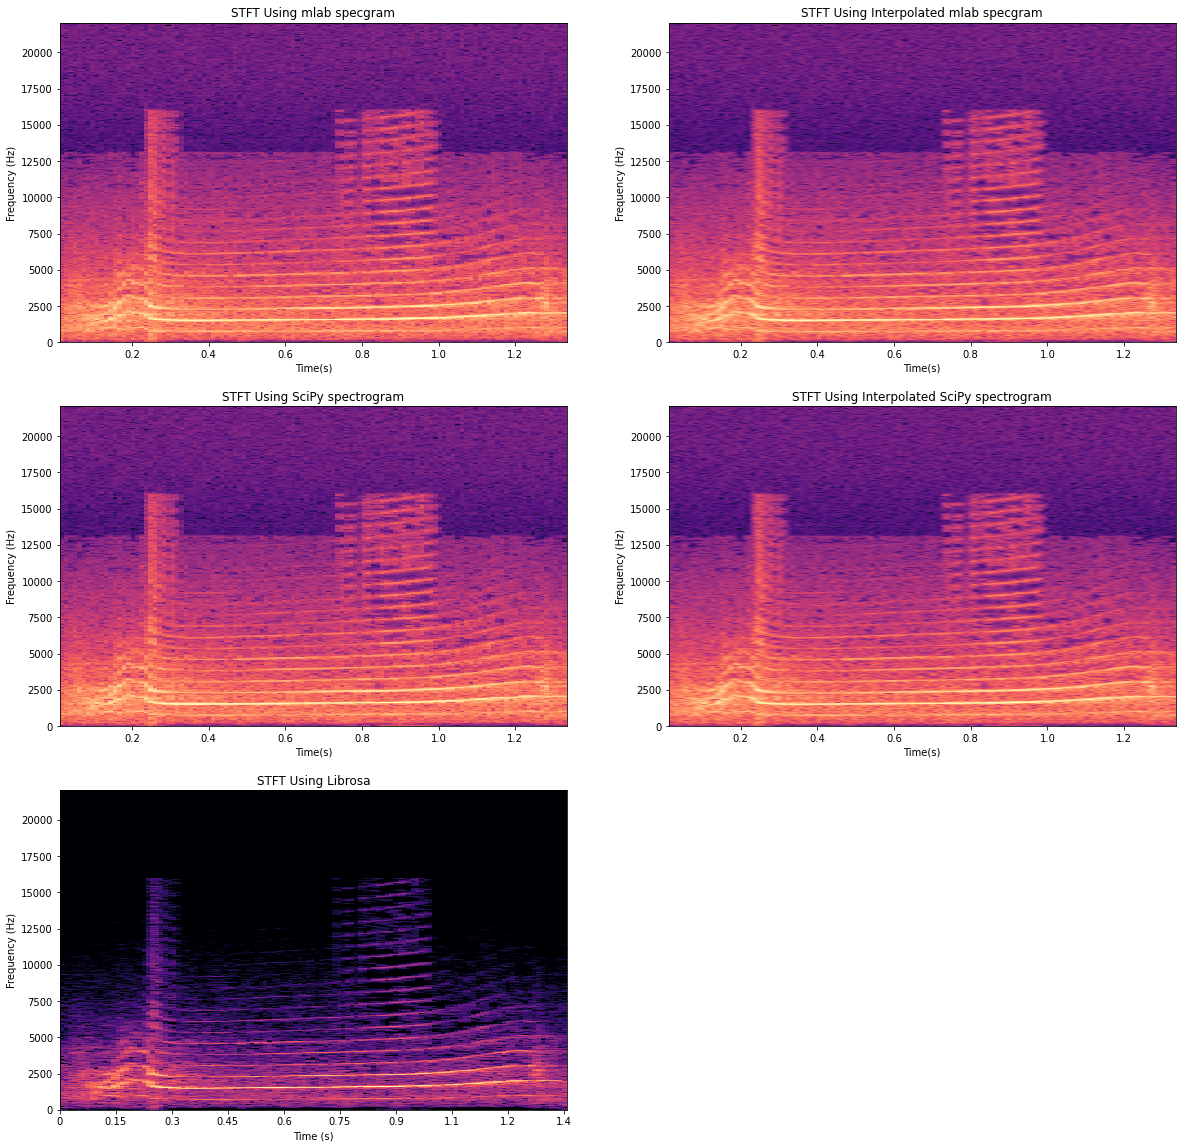

In [35]:
from matplotlib import mlab as mlab
from scipy.signal import spectrogram 
import librosa.display

fig, axs = plt.subplots(3, 2, figsize=(20,20))
spec, f, t = mlab.specgram(data, Fs=sample_rate, NFFT=1024, noverlap=512, window=mlab.window_hanning)
axs[0,0].pcolormesh(t, f, 20*np.log10(spec), cmap='magma')
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Frequency (Hz)')
axs[0,0].set_title('STFT Using mlab specgram')

spec, f, t = interp(spec, f, t)
axs[0,1].pcolormesh(t, f, spec, cmap='magma')
axs[0,1].set_xlabel('Time(s)')
axs[0,1].set_ylabel('Frequency (Hz)')
axs[0,1].set_title('STFT Using Interpolated mlab specgram')

f, t, Sxx = spectrogram(data, fs=sample_rate, window='hann', nperseg=1024, noverlap=1024//2, detrend=False,
                            scaling='spectrum')
axs[1,0].pcolormesh(t, f, 20*np.log10(Sxx), cmap='magma')
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Frequency (Hz)')
axs[1,0].set_title('STFT Using SciPy spectrogram')

Sxx, f, t = interp(Sxx, t, f)
axs[1,1].pcolormesh(t, f, Sxx, cmap='magma')
axs[1,1].set_xlabel('Time(s)')
axs[1,1].set_ylabel('Frequency (Hz)')
axs[1,1].set_title('STFT Using Interpolated SciPy spectrogram')


D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
plt.subplot(3, 2, 5)
librosa.display.specshow(D, y_axis='linear', x_axis='time', cmap='magma', sr=sample_rate)
plt.title('STFT Using Librosa')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

fig.delaxes(axs[2][1])

plt.show()

In general, the different packages all produce the expected results, with minor differences (note that the apperance of the librosa spectrogram can simply be explained by the default threshold used converting to the dB scale with the ``amplitude_to_db`` method). With the being said, SciPy or mlab might be advantageous given their enhanced lower-leverl flexibility relative to librosa.

Before investigating other possible representations of acoustic signals, let's take a look at a few other methods for constructing spectrogram's, using Tim Saingburg's [blog](https://timsainburg.com/category/signal-processing.html) as a reference.

#### Sainburg's Approach to Constructing Spectrograms

While we've already explored a number of options for generating spectrogram representations, we'll discuss a few final methods. We'll begin with some necessary imports:

In [36]:
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

Next, we'll define a few methods to clean the signal.

In [37]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

With these tools prepared, we're now ready to construct our spectrograms. In his blog, Sainburg adopts a super low-level approach, that we include here for completeness. We'll glance over his code with limited commentary.

In [38]:
def overlap(X, window_size=1024, window_step=512):
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))
    
    valid = len(X) - window_size
    nw = valid // window_step
    out = np.ndarray((nw, window_size), dtype=X.dtype)
    
    for i in np.arange(nw):
        start = i * window_step
        stop = start + window_size
        out[i] = X[start:stop]
        
    return out

def stft(X, fftsize=1024, step=512, mean_normalize=True, 
         real=False, compute_onesided=True):
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
        
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()
        
    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d, log=True, thresh=5, fft_size=1024, step_size=512):

    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()
        specgram = np.log10(specgram)
        specgram[
            specgram < -thresh
        ] = -thresh
    else:
        specgram[
            specgram < thresh
        ] = thresh

    return specgram

In [39]:
fft_size = 1024
step_size = fft_size // 2
spec_thresh = 4
lowcut = 500
highcut = 15000

In [40]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

data = butter_bandpass_filter(data, lowcut, highcut, sample_rate, order=1)

In [41]:
wav_spectrogram = pretty_spectrogram(
    data.astype("float64"),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    thresh=spec_thresh,
)

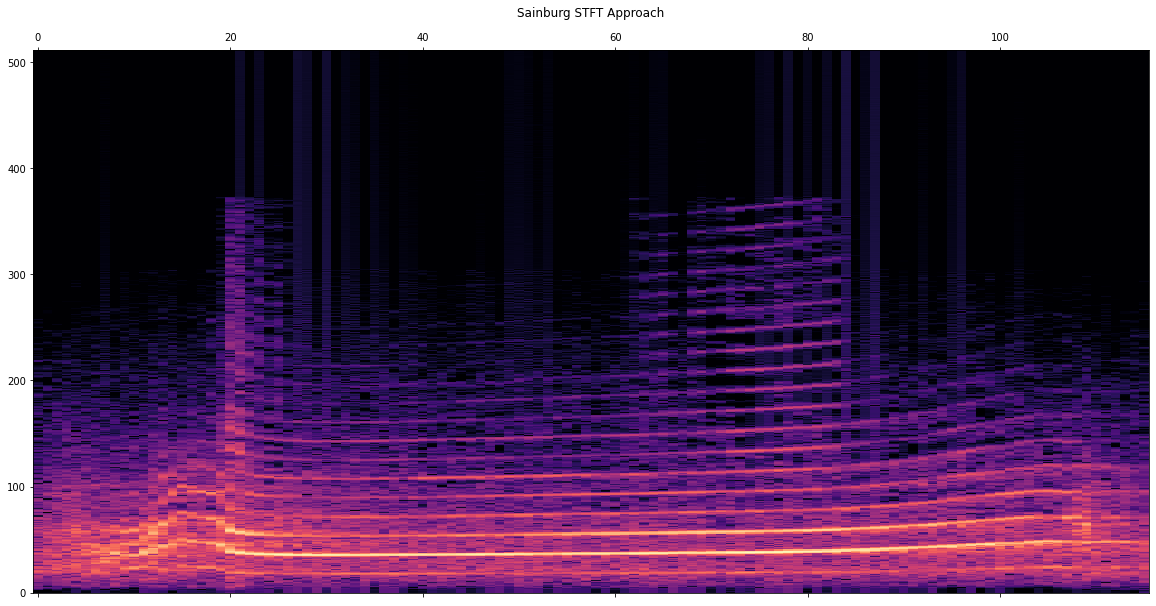

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
cax = ax.matshow(
    np.transpose(wav_spectrogram),
    interpolation="nearest",
    aspect="auto",
    cmap='magma',
    origin="lower",
)
plt.title('Sainburg STFT Approach')
plt.show()

The final step in the Sainburg pipeline involves converting the spectrogram to a melspectrogram, which simply involves a transformation to the mel frequency scale, defined as

$$\text{mel} = 2595*\log10(1+\text{Hz}/700)$$

Again, we provide the code from Sainburg's blog, but for our purposes, we won't dive too deeply into this low-level technique.

In [43]:
def make_mel(spectrogram, mel_filter, shorten_factor=1):
    mel_spec = np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(
        mel_spec.astype("float32"), [1, 1.0 / shorten_factor]
    ).astype("float16")
    mel_spec = mel_spec[:, 1:-1]
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    mel_spec = mel_spec + spec_thresh
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(
        uncompressed_spec.astype("float32"), [1, shorten_factor]
    ).astype("float16")
    uncompressed_spec = uncompressed_spec - 4
    return uncompressed_spec

def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.0)


def mel2hz(mel):
    return 700 * (10 ** (mel / 2595.0) - 1)


def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank


def create_mel_filter(
    fft_size, n_freq_components=64, start_freq=300, end_freq=8000, samplerate=44100
):
    mel_inversion_filter = get_filterbanks(
        nfilt=n_freq_components,
        nfft=fft_size,
        samplerate=samplerate,
        lowfreq=start_freq,
        highfreq=end_freq,
    )

    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

In [44]:
n_mel_freq_components = 64
shorten_factor = 1
start_freq = 300
end_freq = 8000

In [45]:
mel_filter, mel_inversion_filter = create_mel_filter(
    fft_size=fft_size,
    n_freq_components=n_mel_freq_components,
    start_freq=start_freq,
    end_freq=end_freq,
)

In [46]:
mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor=shorten_factor)

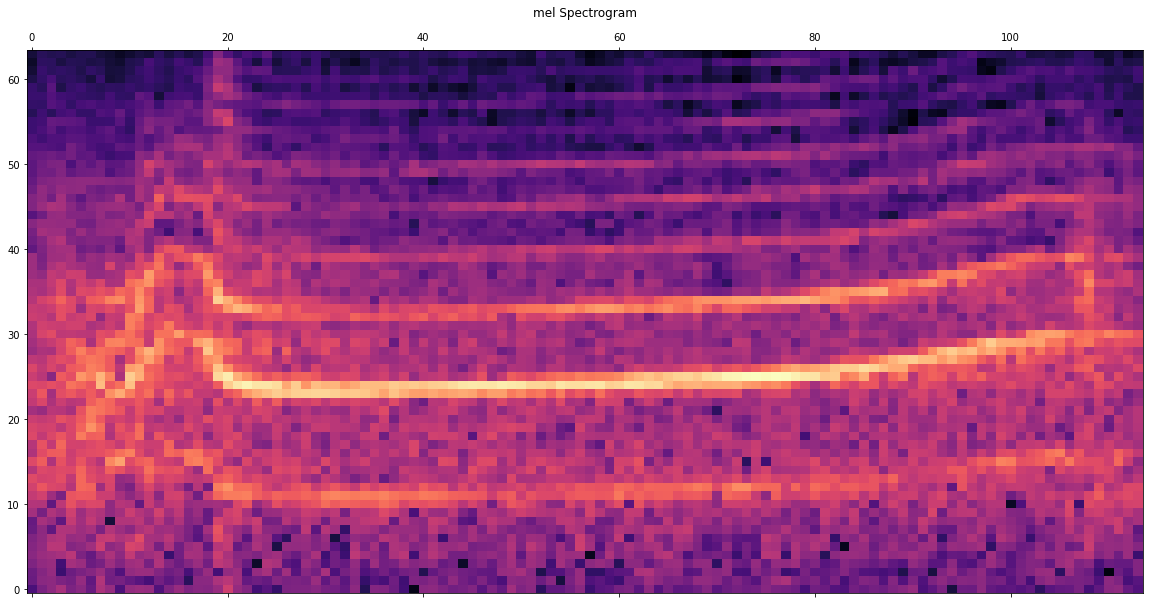

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
cax = ax.matshow(
    mel_spec.astype("float32"),
    interpolation="nearest",
    aspect="auto",
    cmap='magma',
    origin="lower",
)
plt.title("mel Spectrogram")
plt.show()

Before moving on, we'll take a quick look at [this paper](https://arxiv.org/pdf/1709.01922.pdf) to compare audio signal preprocessing methods. The key takeaway is that although there are numerous commonly used input image preprocessing techniques, the vast majority are reduntant with the exception of logarithmic magnitude compression. Let's dive a little deeper.

Essentially, the goal of the paper is to address and optimize possible audio preprocessing strategies for deep convolutional neural networks (CNNs). Melspectrograms (such as that shown directly above) have conventionally been preffered over STFT approaches from an efficient-yet-effective perspective, but logarithmic compression of a time-frequency representation is an alternatively popular method.

Traditionally, STFT and melspectrogram have been the most popular representations, with melspectrograms providing an efficient and perceptually relevant (based on the mechanics of human hearing) representation and spectrograms offering a more faithful representaion of the original signal, enabling neural networks to extract features optimized for a given task. Also, melspectrograms have proved advantageous when using small datasets.

Ultimately, the authors experimented with a number of preprocessing techniques (time-frequency representation, frequency weighting, and magnitude scaling), concluding that the only factor that significantly impacted performance was logarithmic (decibel) magnitude scaling. This is demonstrated in the following plot.

In [48]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

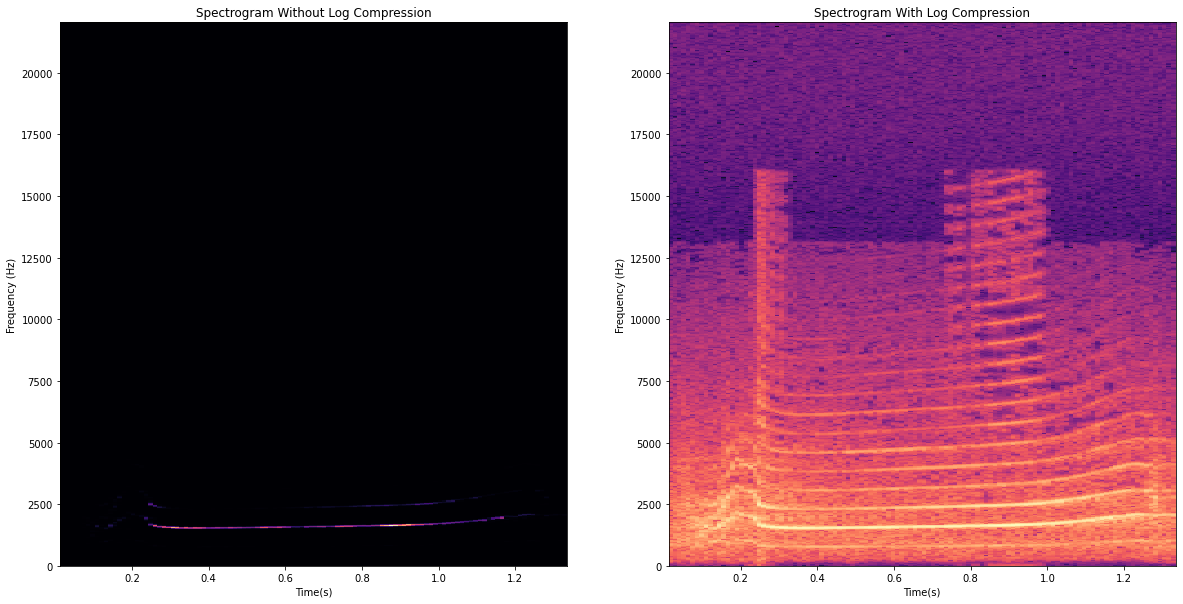

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
spec, f, t = mlab.specgram(data, Fs=sample_rate, NFFT=1024, noverlap=512, window=mlab.window_hanning)
axs[0].pcolormesh(t, f, spec , cmap='magma')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('Spectrogram Without Log Compression')

axs[1].pcolormesh(t, f, 20*np.log10(spec), cmap='magma')
axs[1].set_xlabel('Time(s)')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_title('Spectrogram With Log Compression')
plt.show()

#### Time-Frequency Reassigned Spectrogram

In our last experiment of our spectrogram exploration, let's take a look at an alternative to the convential STFT approach. We'll construct a time-frequency reassigned spectrogram, which has been shown to provide a sharper representation of the signal. Additional information can be found [here](https://arxiv.org/pdf/0903.3080.pdf).

As we've discussed earlier, the spectrogram-based representation of acoustic signals unfortunately demands a tradeoff between spectral and temporal resolution. The time-frequency reassigned (TFR) spectrogram provides a means to achieve sharper resolutions. Here, we will explore this approach to acoustic signal representation.

Unlike the conventional STFT approach, which yields a blurred representation, the TFR method maps data
to time-frequency coordinates that are nearer to the true region of support of the analyzed signal, yielding a sharper representation of the original signal.

For our first exploration of reassigned spectrograms, we'll make use of the ``reassigned_spectrogram`` method in librosa.

In [50]:
from librosa.core import reassigned_spectrogram as librosa_tfr_spec

In [51]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

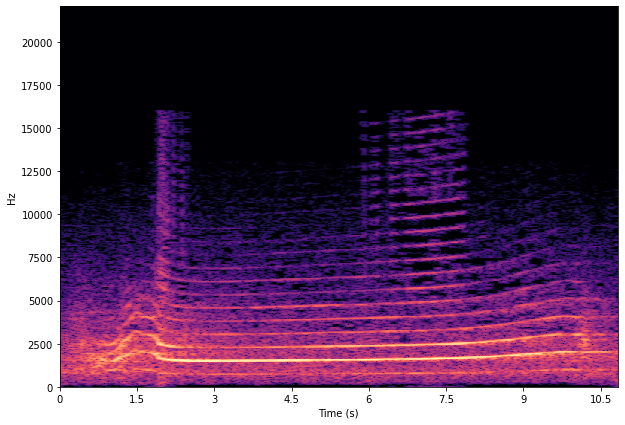

In [52]:
freqs, times, tfr_Sxx = librosa_tfr_spec(y=data, sr=sample_rate, n_fft=1024, hop_length=64)
tfr_Sxx_db = librosa.power_to_db(tfr_Sxx, amin=1e-2)
fig = plt.figure(figsize=(10,7))
librosa.display.specshow(tfr_Sxx_db, x_axis="s", y_axis="linear", sr=sample_rate, hop_length=512, cmap='magma')
plt.show()

We see a moderate improvement in resolution versus the original STFT approach, but let's look at some other modules. Let's use the ``reassigned_spectrogram`` method contained in the tfr package. 

output_frame_count 467


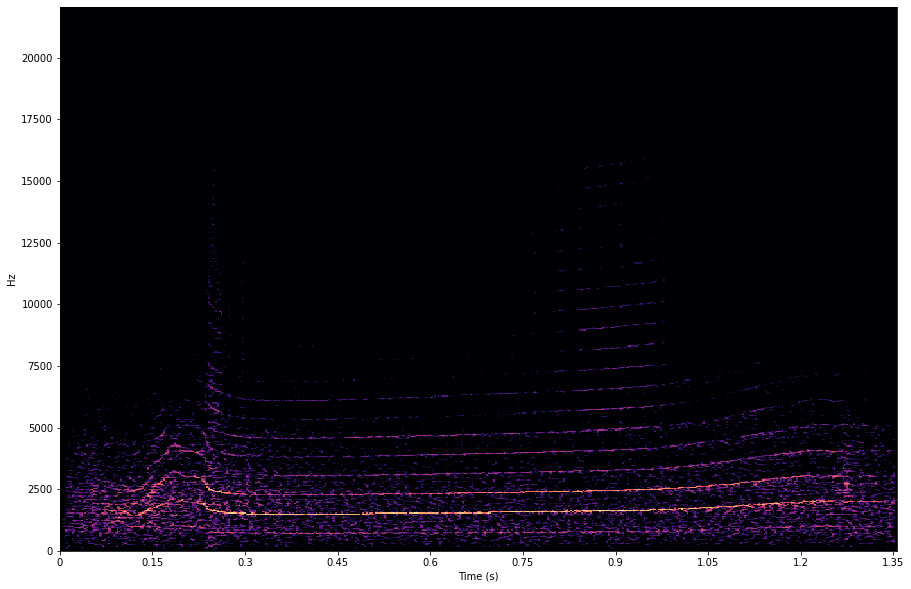

In [53]:
import tfr
import warnings
warnings.simplefilter('ignore', FutureWarning)

signal_frames = tfr.SignalFrames(path_name, frame_size=1024, hop_size=128)
x_spectrogram = tfr.reassigned_spectrogram(signal_frames)
fig = plt.figure(figsize=(15,10))
librosa.display.specshow(x_spectrogram.T, x_axis="s", y_axis="linear", sr=sample_rate, hop_length=128, cmap='magma')
plt.show()

This looks like we might be on the right path to getting improved time-frequency resolution. Finally, we'll show the results using the libtfr package. We'll have to explore the installation of this package more thoroughly, so for now we'll just show a sample image output that we've saved.

![title](TFR-Spectrogram.png)

As we can see, the TFR spectogram generated using the libtfr module provides enhanced resolution that might yield a representation that captures the information contained in the original acoustic signal with a higher degree of fidelity. With this in mind, it would be ideal to further explore this approach, but we'll have to look into a better method for installing the libtfr package, since now the procedure for doing so is somewhat convoluted.

Before concluding our discussion on spectrogram representations, we'll provide a complete pipeline.

#### A Complete Pipeline

After exploring numerous options for constructing spectrograms, we are finally ready to go through the complete pipeline. First, we begin by loading the acoustic waveform of interest.

In [54]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

Next, we'll define a few methods that will help us optimize our spectrogram-based acoustic representation. The procedure is as follows:

* Define a method to construct spectrograms and return time bins, frequency bins, and the spectrogram using librosa's ``reassigned_spectrogram``
* Interpolate the spectogram
* Compute the goodness (using the PCA-motivated approach) for a given spectrogram
* Carry out a parameter grid search to maximize the goodness
* Plot the final spectrogram, removing unnecessary add-ons such as xlabels, ylabels, tick marks, colorbars, etc.

Ultimately, this process culminates in a spectrogram image that would serve as a basis for constructing a dataset of spectrogram images for a machine learning (ML) application.

We'll move forward with constructing a spectrogram:

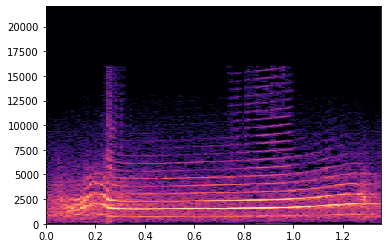

In [55]:
def construct_spectrogram(signal, sr, nfft=1024, hoplength=None, win=scipy.signal.hanning, db_th=1e-2):
    if hoplength is None:
        hoplength = nfft//2

    _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
    spec_db = librosa.power_to_db(spec, amin=db_th)
    f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
    t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
    return t_bins,f_bins, spec_db

t, f, Sxx = construct_spectrogram(data, sample_rate)
plt.pcolormesh(t, f, Sxx, cmap='magma')
plt.show()

Great! Next, we'll smooth spectrogram by carrying out an interpolation using cubic splines.

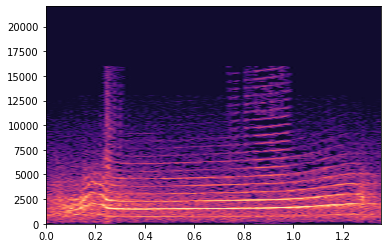

In [56]:
def interp_spectrogram(spec, t, f):
    interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
    
    ts_interp = np.linspace(np.min(t), np.max(t), 1000)
    freqs_interp = np.linspace(np.min(f), np.max(f), 1000)
    spec_interp = interp_fx(ts_interp, freqs_interp)
    
    return spec_interp, freqs_interp, ts_interp

spec_interp, freqs_interp, ts_interp = interp_spectrogram(Sxx, t, f)
spec_interp.shape, freqs_interp.shape, ts_interp.shape
plt.pcolormesh(ts_interp, freqs_interp, spec_interp, cmap='magma')
plt.show()

In order to quantify how "good" are representation is, we'll look at how many PCA features are required to meet a threshold for the explained variance ratio. This serves as a proxy for the amount of meaningful information contained in the representation.

In [57]:
def compute_goodness(spec_interp, n_pca=100, th=0.95):
    pca = PCA(n_components=n_pca)
    pca.fit(spec_interp)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    return feature_i+1

compute_goodness(spec_interp)

14

Now that we've computed the goodness for a default choice of parameters, let's loop through a grid of parameter values in order to optimize the goodness of the representation. This is achived using the ``optimize_spectrogram`` method:

In [58]:
def optimize_spectrogram(signal, sr, p_nffts=np.arange(3, 15)):
    
    metrics = []
    for p in p_nffts:
        t, f, Sxx = construct_spectrogram(signal, sr, nfft=2**p)
        Sxx_interp, f_interp, t_interp = interp_spectrogram(Sxx, t, f)
        goodness = compute_goodness(Sxx_interp)
        metrics.append(goodness)
    
    idx = metrics.index(np.max(metrics))
    return p_nffts[idx]

    
opt_p = optimize_spectrogram(data, sample_rate)
print(f'Optimal Window Size: nfft={2**opt_p}')

Optimal Window Size: nfft=1024


Finally, we can plot the optimized spectrogram representation. For an actual ML application, we would save a collection of spectrograms with appropriate labels for the given task of interest. Also, note that when constructing a dataset comprised of an ensemble of spectrograms, it is crucial to normalize the colorbar using the ``vmin`` and ``vmax`` arguments.

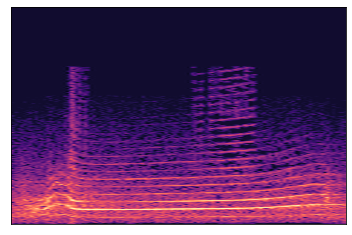

In [59]:
def plot_spectrogram(signal, sr, opt_nnft=1024, amin=1e-2, norm=True):
    t, f, Sxx = construct_spectrogram(signal, sr, nfft=opt_nnft, db_th=amin)
    Sxx_interp, f_interp, t_interp = interp_spectrogram(Sxx, t, f)
    
    if norm:
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma', vmin=-24, vmax=21)
    else:
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')    
    plt.xticks([])
    plt.yticks([])

plot_spectrogram(data, sample_rate)

We'll reiterate the importance of the colorbar normalization with the following plot:

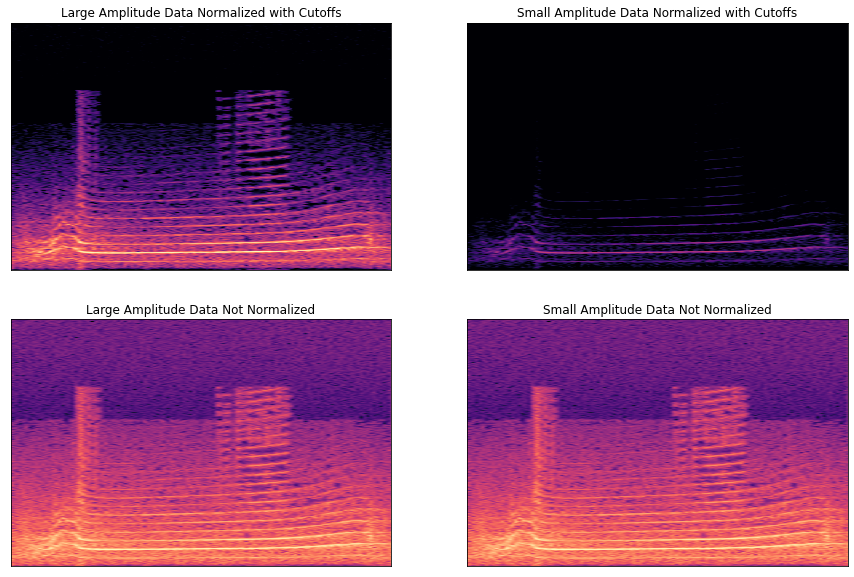

In [60]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plot_spectrogram(data, sample_rate, amin=1e-10)
plt.title('Large Amplitude Data Normalized with Cutoffs')
plt.subplot(2, 2, 2)
plot_spectrogram(0.01*data, sample_rate, amin=1e-10)
plt.title('Small Amplitude Data Normalized with Cutoffs')
plt.subplot(2, 2, 3)
plot_spectrogram(data, sample_rate, amin=1e-10, norm=False)
plt.title('Large Amplitude Data Not Normalized')
plt.subplot(2, 2, 4)
plot_spectrogram(0.01*data, sample_rate, amin=1e-10, norm=False)
plt.title('Small Amplitude Data Not Normalized')
plt.show()

As shown in the above plots, it is absolutely necessary to ensure that spectrograms are properly normalized when constructing a dataset containing different desired classes.

This concludes our exploration of spectrogram representations. Let's continue with some other acoustic signal representations.

#### Addendum: Using the libtfr Package

While the installation procedure for the libtfr package is rather complicated and would benefit from an update, here we demonstrate the advantages of using the time-frequency reassigned approach implemented in this module. We start off by importing libtfr:

In [65]:
import libtfr

For the first application, let's take a look at the orca call.

In [66]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

In [67]:
nfft = 1024
Np = nfft
shift = nfft/16
K = 6
tm = 6.0
flock = 0.01
tlock = 5

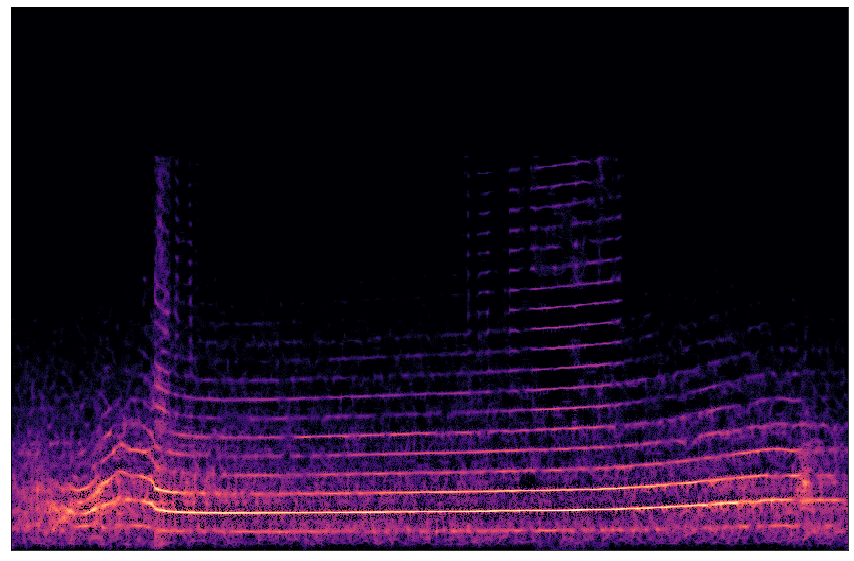

In [68]:
S = np.abs(libtfr.tfr_spec(s=data, N=nfft, step=shift, Np=Np, K=K, tm=tm, flock=flock, tlock=tlock))
S = librosa.amplitude_to_db(S, ref=np.max, top_db = 140)
fig, ax = plt.subplots(figsize=(15,10))
librosa.display.specshow(S, y_axis='linear', cmap='magma')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.savefig('TFR-Spectrogram.png')
plt.show()

Clearly, the above spectrogram reveals an incredibly high degree of resolution that cannot be achieved using the STFT approach. But how does this approach work with a transient signal? To address this question, let's return to the sperm whale click.

In [69]:
data_path = '/home/radek/workspace/sperm_whale/data'
annos = '/home/radek/workspace/sperm_whale/annotations/all_codas_with_frames.csv'
annos_df = pd.read_csv(annos)
annos_df.head()

codaNUM2018            REC  nClicks  Duration      ICI1      ICI2  \
0         4931  sw061b001_124       17  0.927792  0.033950  0.036117   
1         4932  sw061b001_124       20  1.092992  0.032817  0.039358   
2         4933  sw061b001_124        5  0.898250  0.275850  0.286783   
3         4934  sw061b001_124        5  0.865575  0.262275  0.276883   
4         4935  sw061b001_124        5  0.858317  0.266675  0.269358   

       ICI3      ICI4      ICI5      ICI6  ...  IPI37  IPI38  IPI39  IPI40  \
0  0.048867  0.048908  0.042275  0.040483  ...    0.0    0.0    0.0    0.0   
1  0.045325  0.049933  0.044083  0.044783  ...    0.0    0.0    0.0    0.0   
2  0.197400  0.138217  0.000000  0.000000  ...    0.0    0.0    0.0    0.0   
3  0.183333  0.143083  0.000000  0.000000  ...    0.0    0.0    0.0    0.0   
4  0.178325  0.143958  0.000000  0.000000  ...    0.0    0.0    0.0    0.0   

   start_time                path  sample_rate       filename  start_frame  \
0    126.0372  2015/sw061b001.wav       120000  sw061b001.wav     15124464   
1    128.3256  2015/sw061b001.wav       120000  sw061b001.wav     15399072   
2    131.7476  2015/sw061b001.wav       120000  sw061b001.wav     15809712   
3    135.5877  2015/sw061b001.wav       120000  sw061b001.wav     16270524   
4    139.5217  2015/sw061b001.wav       120000  sw061b001.wav     16742604   

   duration_in_frames  
0              111334  
1              131159  
2              107790  
3              103869  
4              102997  

[5 rows x 104 columns]

In [70]:
x = annos_df.iloc[2]
wf, sr = extract_click(x)
t = np.arange(0, len(wf)) / sr

In [71]:
nfft = 256
Np = nfft
shift = nfft/2
K = 6
tm = 6.0
flock = 0.01
tlock = 5

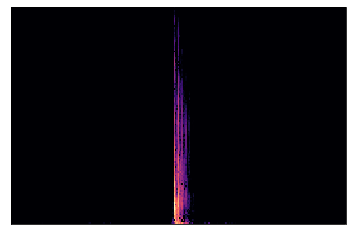

In [72]:
S = np.abs(libtfr.tfr_spec(s=wf[:,0], N=nfft, step=shift, Np=Np, K=K, tm=tm, flock=flock, tlock=tlock))
S = librosa.amplitude_to_db(S, ref=np.max, top_db = 140)
fig, ax = plt.subplots(figsize=(6,4))
librosa.display.specshow(S, y_axis='linear', cmap='magma')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

### Hilbert Huang Transform

After having explored the spectrogram representation, let's move on to the an alternative time-frequency representation known as the Hilbert Huang Transform, or HHT. Unlike the Fourier transform, which was developed as a theoretical tool, the HHT is an algorithmic/empirical/data-driven approach designed to work effectively for nonstationary and nonlinear time series. At its core, the HHT involves decomposing a signal into intrinsic mode functions (IMFs), via a process known as empirical mode decomposition (EMD).

This [paper](https://asa.scitation.org/doi/10.1121/1.2354003) offers insight into the application of HHTs to marine mammal bioacoustics, and [this](https://www.sciencedirect.com/science/article/abs/pii/S0003682X06000764) one addresses the use of HHTs to investigate transient sperm whale clicks, in particular. The HHT approach to bioacoustics demonstrates several advantages over conventional spectrogram-based approaches. These include (1) improved temporal and spectral resolution relative to the STFT spectrogram approach, since the HHT is not theoretically confined by the uncertainty principle; (2) the original signal decomposition into successive modes is complete; and (3) the frequency evolution for each mode can be analyzed as a one-dimensional (1D) signal. With this brief introduction, let's get started with this algorithm.

We begin with a few imports:

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from PyEMD import EMD
from scipy.signal import hilbert
from scipy import interpolate

Next, we'll load the Watkins sperm whale coda (``_sw``) and, as before, plot a single click for completeness. We'll also use the orca N01 call (``_orca``) for comparison.

In [64]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[25000:45000]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))

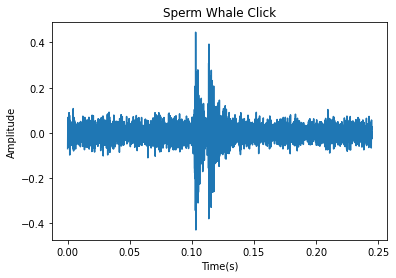

In [65]:
plt.plot(time_sw, signal_sw)
plt.title('Sperm Whale Click')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.show()

In [66]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))

Now the fun begins! Briefly, we'll give a synopsis of the mathematics involved in carrying out the HHT. The procedure begins with empirical mode decomposition (EMD) using this [textbook](https://www.cambridge.org/core/books/passive-acoustic-monitoring-of-cetaceans/8D59083194B2634B9F490635EAF23653) as a reference. This entails decomposing the original signal $x(t)$ into a series of oscillating functions $C_n(t)$ and a non-oscillatory final trend $R_N(t)$.

$$x(t) = \sum_{n=1}^NC_n(t) + R_N(t)$$

The $C_n(t)$ functions are called intrinsic mode functions (IMFs), and they are characterized by a decreasing number of zero crossings with increasing $n$.

Here, we'll make use of the ``EMD`` method in the ``PyEMD`` module to plot the IMFs for the signals.

In [67]:
labels = ['Sperm Whale', 'Orca']
signals = [signal_sw, signal_orca]
times = [time_sw, time_orca]
srs = [sr_sw, sr_orca]

In [68]:
emd = EMD()
imfs_sw_orca = [emd(signal_sw), emd(signal_orca)]

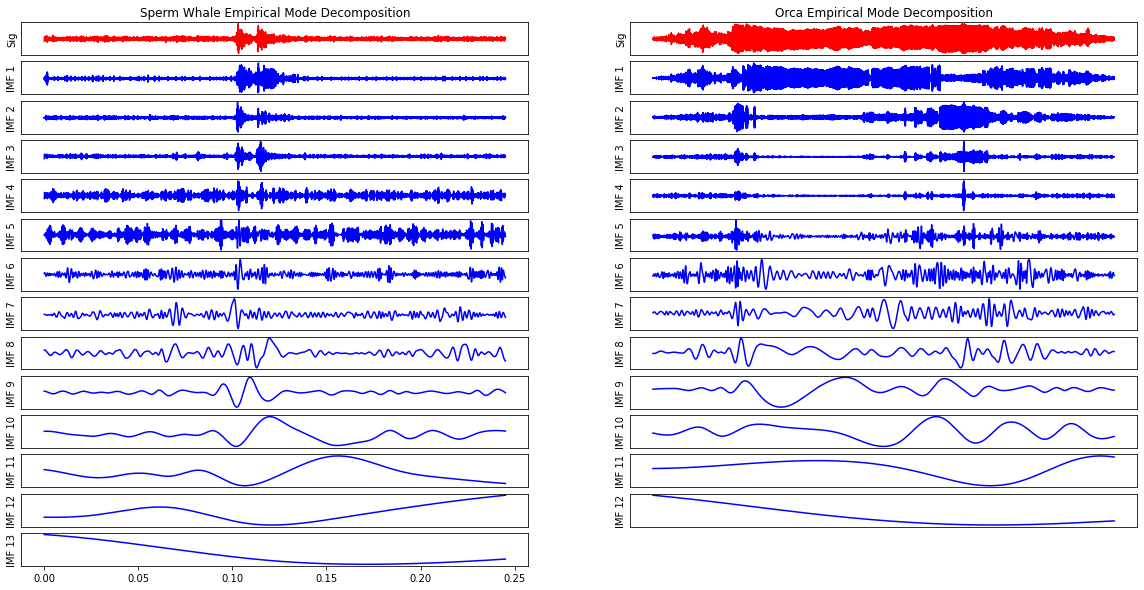

In [69]:
n_max = 13
fig, axs = plt.subplots(n_max+1, 2, figsize=(20,10))
for idx, imfs in enumerate(imfs_sw_orca):
    label = labels[idx]
    signal = signals[idx]
    time = times[idx]
    
    axs[0, idx].plot(time, signal, color='r')
    axs[0, idx].set_xticks([])
    axs[0, idx].set_yticks([])
    axs[0, idx].set_ylabel('Sig')
    axs[0, idx].set_title(f'{label} Empirical Mode Decomposition')
    
    try:
        for i in range(n_max):
            axs[i+1, idx].plot(time, imfs[i,:], color='blue')
            axs[i+1, idx].set_ylabel(f'IMF {i+1}')
            axs[i+1, idx].set_yticks([])
            if i < n_max-1:
                axs[i+1, idx].set_xticks([])
            if i == n_max:
                axs[i+1, idx].set_xlabel('Time (s)')
    except IndexError:
        fig.delaxes(axs[-1][1])
plt.show()


Following this decomposition, can proceed with the HHT. In the following, we'll let $s(n)$ represent the value of the signal at time step $n$, since we are working with discrete time series. The Hilbert transform of a signal (denoted $s_H(n)$) is obtained by convolving the signal with $\frac{1}{\pi n}$:

$$s_H(n) = s(n) \ast \frac{1}{\pi n}$$

Next, we define the analytic signal $s_A(n)$:

$$s_A(n) = s(n) + i s_H(n) = a(n)e^{i\theta(n)} \hspace{2mm} \text{where} \hspace{2mm} a(n) \equiv \sqrt{s^2(n) + s_H^2(n)} \hspace{2mm} \text{and} \hspace{2mm} \theta(n)\equiv \arctan{[s_H(n) / s(n)]}$$

From this, we obtain the instantaneous frequency at each time step $n$ by evaluating:

$$f(n) = \frac{1}{2\pi}\frac{d\theta(n)}{dn}$$

With this framework in place, we'll define our own custom class to carry out this transform.

In [70]:
class HHT(object):
    
    def __init__(self, signal, time, fs):
        self.signal = signal
        self.time = time
        self.fs = fs
        
    def emd(self):
        calc_emd = EMD()
        imfs = calc_emd(self.signal)
        return imfs
    
    def ht(self, t_res=128, f_res=256, ylim=20000, amin=1e-2):
        s = self.signal
        t = self.time
        N = len(t)
        Ts = 1 / self.fs
        
        t_bins = np.linspace(0, np.max(t), t_res)
        t_dig = np.digitize(t, t_bins)-1
        
        f_bins = np.linspace(0, 16, f_res)
        f_bins = 2**f_bins
        
        imfs = self.emd()
        K = imfs.shape[0]
        
        HS = np.zeros((t_res, f_res))
        for i in range(K):
            x = imfs[i, :]

            H = hilbert(x)
            H_imag = H.imag
            H_amp = np.abs(H)

            dH_imag = np.diff(H_imag)
            dH_imag = np.insert(dH_imag, len(dH_imag), dH_imag[-1])

            dx = np.diff(x)
            dx = np.insert(dx, len(dx), dx[-1])

            w = (x*dH_imag - H_imag*dx) / (H_amp**2)
            freq = w*self.fs / (2*np.pi)

            f_dig = np.digitize(freq, f_bins)

            for idx in range(N):
                if f_dig[idx] < f_res:
                    HS[t_dig[idx], f_dig[idx]] += H_amp[idx]

        HS_dB = 20*np.log10(HS + amin)
        
        tt, ff = np.meshgrid(t_bins, f_bins)
        
        return tt, ff, HS_dB
    
    def interp_rep(self, ts, fs, hs, n_points=1000, ylim=20000):
        f = interpolate.RectBivariateSpline(ts, fs, hs)

        t_interp = np.linspace(0, ts[-1], n_points)
        f_interp = np.linspace(0, fs[-1], n_points)

        hs_interp = f(t_interp, f_interp)

        tt, ff = np.meshgrid(t_interp, f_interp)
        return tt, ff, hs_interp
    
    def plot_rep(self, t_mesh, f_mesh, HS_arr, ylim=20000, interp=False, vis_details=True, vis=True):
        
        if interp:
            t_mesh, f_mesh, HS_arr = self.interp_rep(t_mesh[0, :], f_mesh[:, 0], HS_arr, ylim=ylim)
        fig = plt.figure()
        plt.pcolormesh(t_mesh, f_mesh, HS_arr.T, cmap='magma')
        plt.ylim([0, ylim])
        if vis_details:
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Hilbert Huang Spectrum')
        else:
            plt.xticks([])
            plt.yticks([])
        if vis:
            plt.show()

Cool! With our new ``HHT`` class, let's represent our sperm whale and orca signals. We'll first plot the Hilbert spectrum of the sperm whale click:

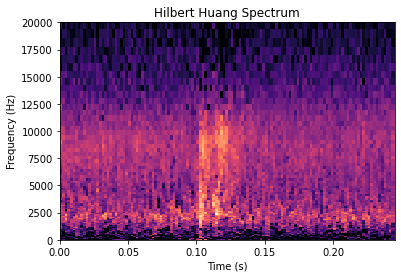

In [71]:
hht_sw = HHT(signal_sw, time_sw, sr_sw)
imfs_sw = hht_sw.emd()
tt_sw, ff_sw, HS_dB_sw = hht_sw.ht()
hht_sw.plot_rep(tt_sw, ff_sw, HS_dB_sw)

Looks good! Now let's interpolate it and remove the plot labels as if we are preparing for a machine learning application.

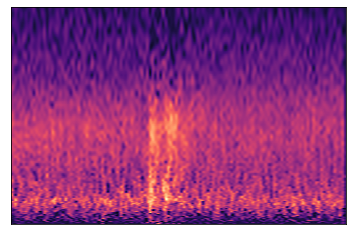

In [72]:
hht_sw.plot_rep(tt_sw, ff_sw, HS_dB_sw, interp=True, vis_details=False)

Awesome! Comparing this with the original spectrogram provides important insight. Below we'll plot the interpolated spectrogram.

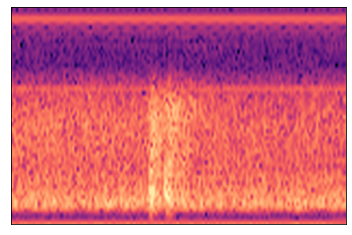

In [73]:
def interp_spec(spec, freqs, ts, ylim=20000):
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(spec), kind='cubic')
    
    ts_interp = np.linspace(t.min(), t.max(), 1000)
    freqs_interp = np.linspace(f.min(), ylim, 1000)
    spec_interp = interp_fx(ts_interp, freqs_interp)
    
    return spec_interp, freqs_interp, ts_interp

f, t, Sxx = scipy.signal.spectrogram(signal_sw, fs=sr_sw, window='hann', nperseg=256, noverlap=256//2, detrend=False, scaling='spectrum')
Sxx, f, t = interp_spec(Sxx, t, f)
plt.pcolormesh(t, f, Sxx, cmap='magma')
plt.xticks([])
plt.yticks([])
plt.show()

Finally, we'll adjust our goodness method and evaluate the goodness of these representations.

In [74]:
def rep_goodness(rep, n_pca=150, th=0.95, vis=True):
    pca = PCA(n_components=n_pca)
    pca.fit(rep)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

In [75]:
hht_sw = HHT(signal_sw, time_sw, sr_sw)
imfs_sw = hht_sw.emd()
tt_sw, ff_sw, HS_dB_sw = hht_sw.ht()
tt_sw, ff_sw, HS_dB_sw = hht_sw.interp_rep(tt_sw[0, :], ff_sw[:, 0], HS_dB_sw)
hht_goodness = rep_goodness(HS_dB_sw)

Number of Features to Exceed Threshold th=0.95: 51


In [76]:
spec_goodness = rep_goodness(Sxx)

Number of Features to Exceed Threshold th=0.95: 10


As we can see, the HHT approach yields a representation containing a greater number of salient features, as determined by a PCA approach! This is great, since we want to provide our ML models with meaningful representations from which the network can extract features enabling it to carry the particular tasks of interest.

As a last step, let's look at the orca signal using the HHT representation:

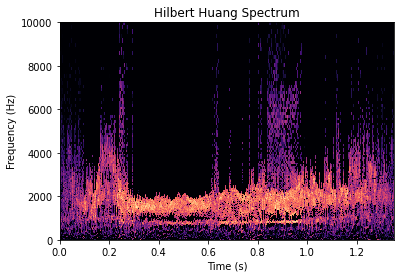

In [77]:
hht_orca = HHT(signal_orca, time_orca, sr_orca)
imfs_orca = hht_orca.emd()
tt_orca, ff_orca, HS_dB_orca = hht_orca.ht(t_res=512, f_res=512)
hht_orca.plot_rep(tt_orca, ff_orca, HS_dB_orca, ylim=10000)

And now the interpolated version without the plot labels:

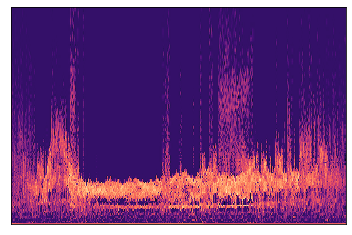

In [78]:
hht_orca.plot_rep(tt_orca, ff_orca, HS_dB_orca, ylim=10000, interp=True, vis_details=False)

This concludes our discussion ofthe HHT approach. Now let's move on to yet another, the continuous wavelet transform representation.

### Continuous Wavelet Transform Representation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pywt

In [3]:
path_name = '/home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff'
signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))
T_orca = 1 / sr_orca

In [4]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[31000:37500]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))
T_sw = 1 / sr_sw

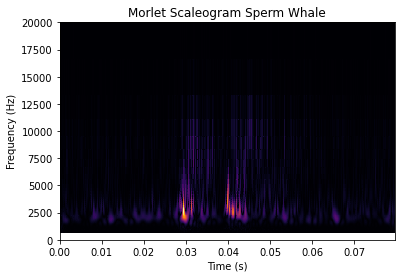

In [5]:
cwtmatr_sw, freqs_sw = pywt.cwt(signal_sw, np.arange(1, 128), "morl", sampling_period = T_sw)
fmax_sw, fmin_sw = pywt.scale2frequency('morl', 1)/T_sw, pywt.scale2frequency('morl', 128)/T_sw
plt.pcolormesh(time_sw, freqs_sw, np.abs(cwtmatr_sw), vmin=0, cmap = "inferno" )  
plt.ylim([0, 20000])
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Sperm Whale")
plt.show()

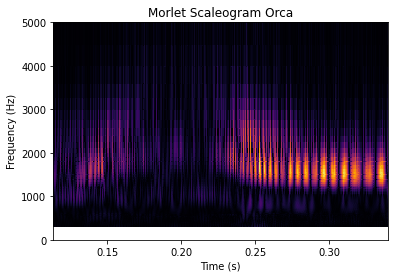

In [6]:
cwtmatr_orca, freqs_orca = pywt.cwt(signal_orca[5000:15000], np.arange(6, 512), "morl", sampling_period = T_orca)
fmax_orca, fmin_orca = pywt.scale2frequency('morl', 6)/T_orca, pywt.scale2frequency('morl', 512)/T_orca
plt.pcolormesh(time_orca[5000:15000], freqs_orca, np.abs(cwtmatr_orca), vmin=0, cmap = "inferno" )  
plt.ylim([0, 5000])
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Orca")
plt.show()

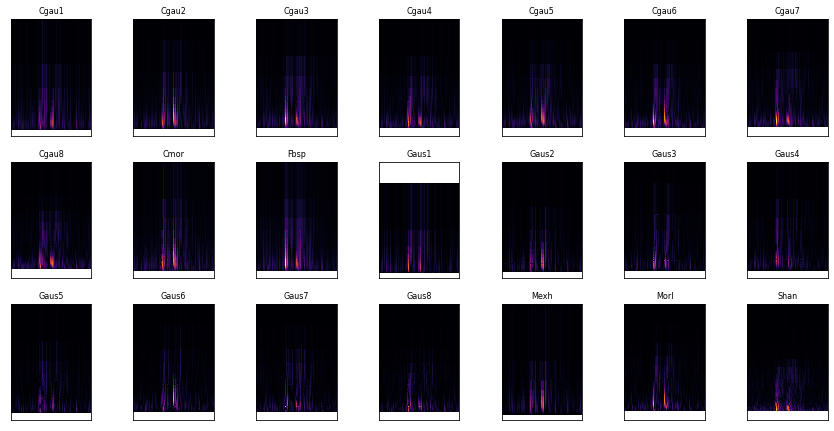

In [7]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

wavlist = pywt.wavelist(kind='continuous')
fig, axes = plt.subplots(3, 7, figsize=(12,6))
fig.tight_layout(pad=0.5)
axs = axes.flatten()
for i, wl in enumerate(wavlist):
    cwtmatr_sw, freqs_sw = pywt.cwt(signal_sw, np.arange(1, 128), wl, sampling_period = T_sw)
    axs[i].pcolormesh(time_sw, freqs_sw, np.abs(cwtmatr_sw), vmin=0, cmap = "inferno" )  
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{wl.capitalize()}', fontsize=8)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

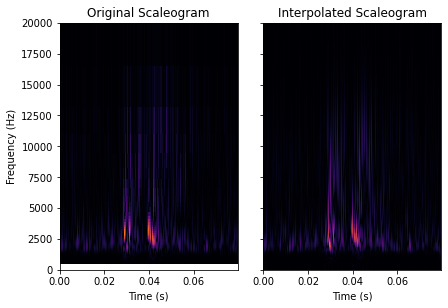

In [36]:
from scipy import interpolate
def interp_rep(ts, fs, rep, n_points=1000, ylim=20000):
    f = interpolate.RectBivariateSpline(ts, fs, rep)

    t_interp = np.linspace(0, ts[-1], n_points)
    f_interp = np.linspace(0, fs[-1], n_points)

    rep_interp = f(t_interp, f_interp)

    tt, ff = np.meshgrid(t_interp, f_interp)
    return tt, ff, rep_interp

ts_sw = time_sw
rep_sw, fs_sw = pywt.cwt(signal_sw, np.flip(np.arange(1, 128)), 'morl', sampling_period = T_sw)
tt_sw, ff_sw, rep_sw_in = interp_rep(ts_sw, fs_sw, rep_sw.T)
fig, axs = plt.subplots(1,2, sharey=True)
fig.tight_layout(pad = 1.0)
axs[0].pcolormesh(ts_sw, fs_sw, np.abs(rep_sw), cmap='inferno')
axs[0].set_ylabel('Frequency (Hz)')
axs[1].pcolormesh(tt_sw, ff_sw, np.abs(rep_sw_in.T), cmap='inferno')
for i, l in enumerate(['Original', 'Interpolated']):
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{l} Scaleogram')
    axs[i].set_xlabel('Time (s)')
plt.show()

In [41]:
from sklearn.decomposition import PCA
from itertools import count
def rep_goodness(rep, n_pca=150, th=0.95, vis=True):
    pca = PCA(n_components=n_pca)
    pca.fit(rep)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

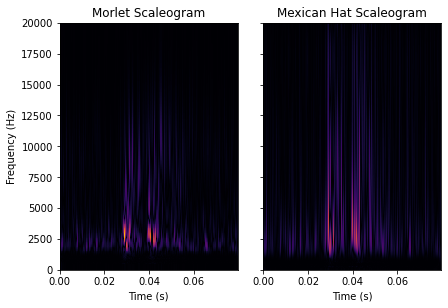

Number of Features to Exceed Threshold th=0.95: 6
Number of Features to Exceed Threshold th=0.95: 3


In [43]:
ts_morl = time_sw
rep_morl, fs_morl = pywt.cwt(signal_sw, np.flip(np.arange(1, 128)), 'morl', sampling_period = T_sw)
tt_morl, ff_morl, rep_morl_in = interp_rep(ts_morl, fs_morl, rep_morl.T)
rep_morl_in = rep_morl_in.T

ts_mexh = time_sw
rep_mexh, fs_mexh = pywt.cwt(signal_sw, np.flip(np.arange(1, 128)), 'mexh', sampling_period = T_sw)
tt_mexh, ff_mexh, rep_mexh_in = interp_rep(ts_mexh, fs_mexh, rep_mexh.T)
rep_mexh_in = rep_mexh_in.T

fig, axs = plt.subplots(1,2, sharey=True)
fig.tight_layout(pad = 1.0)
axs[0].pcolormesh(tt_morl, ff_morl, np.abs(rep_morl_in), cmap='inferno')
axs[0].set_ylabel('Frequency (Hz)')
axs[1].pcolormesh(tt_mexh, ff_mexh, np.abs(rep_mexh_in), cmap='inferno')
for i, l in enumerate(['Morlet', 'Mexican Hat']):
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{l} Scaleogram')
    axs[i].set_xlabel('Time (s)')
plt.show()

morl_goodness = rep_goodness(np.abs(rep_morl_in))
mexh_goodness = rep_goodness(np.abs(rep_mexh_in))

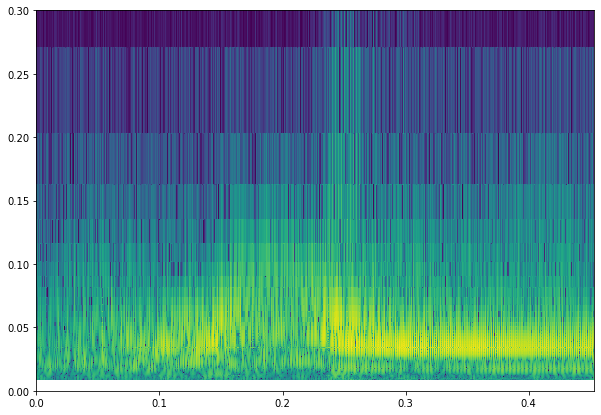

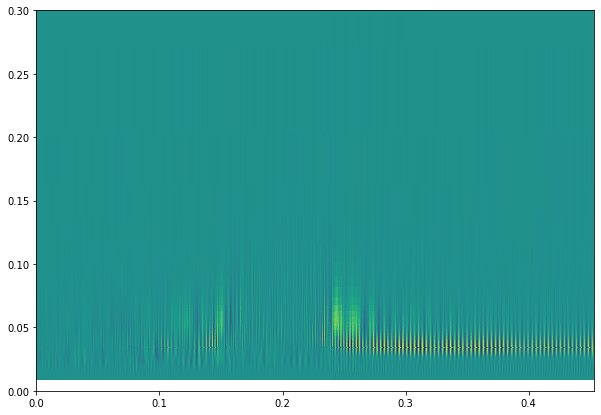

In [165]:
Ts = 1 /sample_rate
wavelet = 'morl'
scale = 32
sig_cwt = data[0:20000]
freq_cwt = pywt.scale2frequency(wavelet, 4) / Ts
time_cwt = np.linspace(0, len(sig_cwt)/sample_rate, len(sig_cwt))


coef, freqs_cwt=pywt.cwt(sig_cwt,np.arange(1,256),'morl')

tt_cwt, ff_cwt = np.meshgrid(time_cwt, freqs_cwt)
plt.figure(figsize=(10,7))
plt.pcolormesh(tt_cwt, ff_cwt, 20*np.log10(np.abs(coef)+1e-4))
plt.ylim([0, 0.3])
plt.show()

plt.figure(figsize=(10,7))
plt.pcolormesh(tt_cwt, ff_cwt, coef)
plt.ylim([0, 0.3])
plt.show()

### Spectral Hyperresolution Representation

In [79]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

In [80]:
from spectral_hyperresolution.linear_reassignment import high_resolution_spectrogram
data_2 = data.reshape(data.shape[0], 1)

q = 2
tdeci = 225
over = 20
noct = 24
minf = 4e-3
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

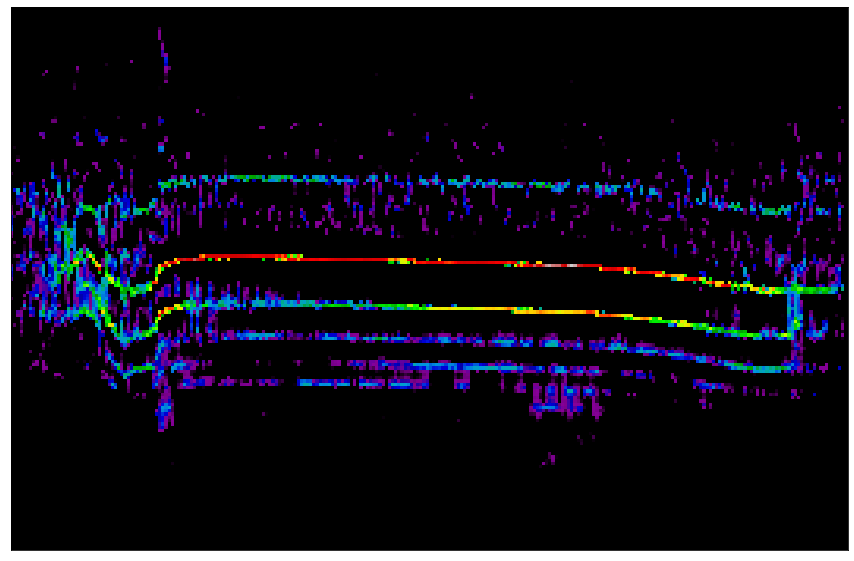

In [81]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.xticks([])
plt.yticks([])
plt.show()

In [82]:
import torch
from spectral_hyperresolution.linear_reassignment_pytorch import high_resolution_spectrogram

In [83]:
%%time
q = 2
tdeci = 225
over = 20
noct = 24
minf = 4e-3 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

CPU times: user 1min 19s, sys: 212 ms, total: 1min 20s
Wall time: 1min 22s


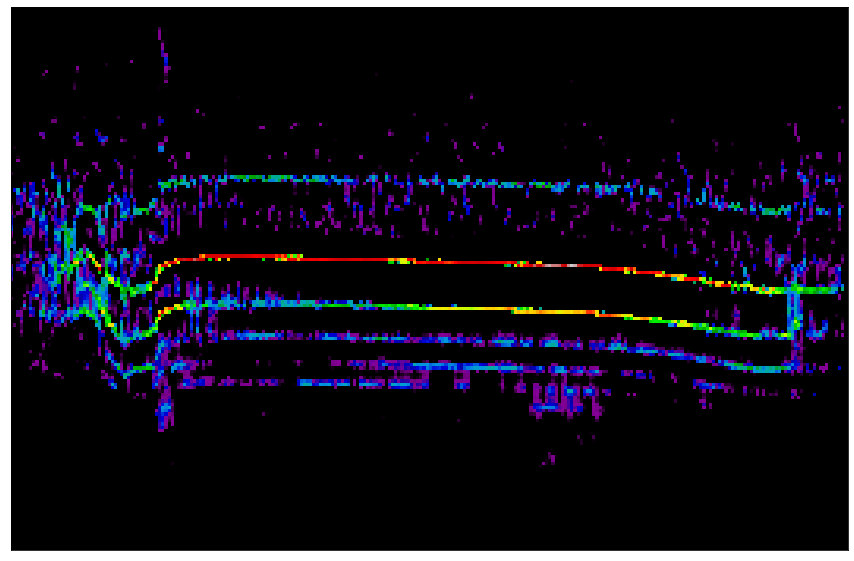

In [84]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.xticks([])
plt.yticks([])
plt.show()

In [85]:
%%time
q = 8
tdeci = 225
over = 40
noct = 24
minf = 4e-2 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

CPU times: user 1min 23s, sys: 64 ms, total: 1min 23s
Wall time: 1min 23s


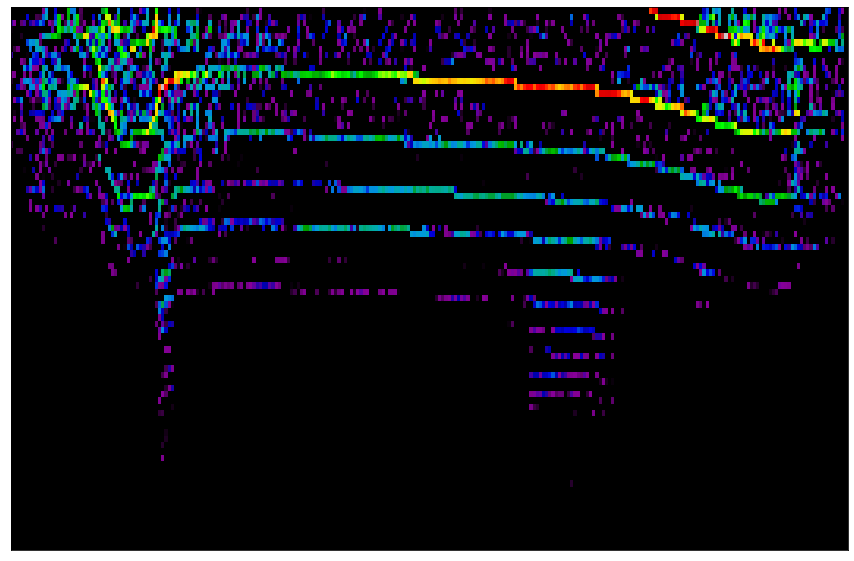

In [86]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.xticks([])
plt.yticks([])
plt.show()

In [87]:
%%time
q = 8
tdeci = 100
over = 40
noct = 24
minf = 4e-2 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

CPU times: user 1min 24s, sys: 128 ms, total: 1min 24s
Wall time: 1min 25s


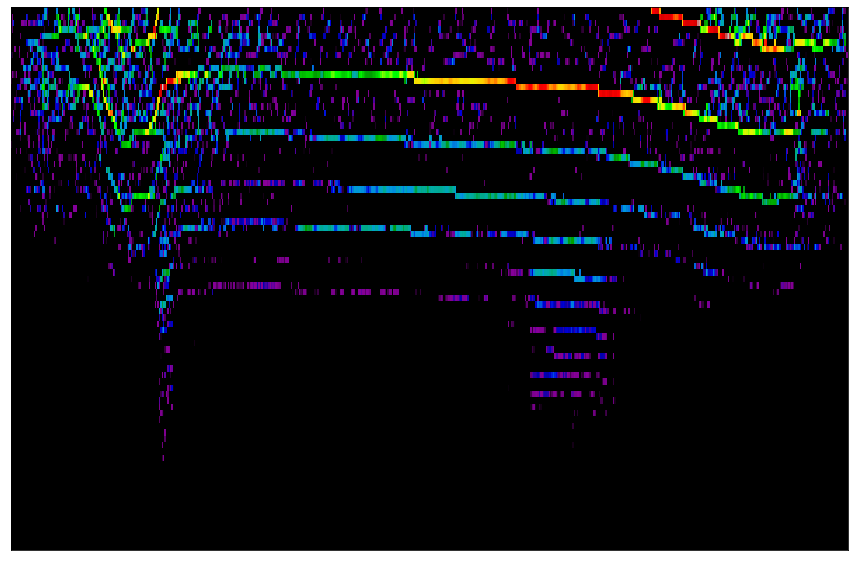

In [88]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.xticks([])
plt.yticks([])
plt.show()

In [89]:
%%time
q = 8
tdeci = 10
over = 40
noct = 24
minf = 4e-2 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

CPU times: user 1min 26s, sys: 240 ms, total: 1min 26s
Wall time: 1min 27s


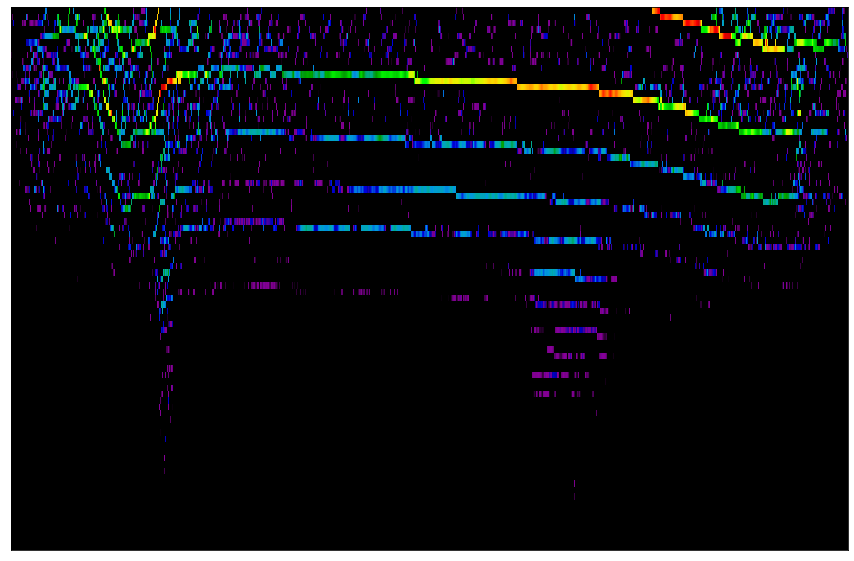

In [90]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.xticks([])
plt.yticks([])
plt.show()

In [91]:
%%time
q = 8
tdeci = 10
over = 40
noct = 48
minf = 4e-2 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

CPU times: user 2min 47s, sys: 236 ms, total: 2min 47s
Wall time: 2min 49s


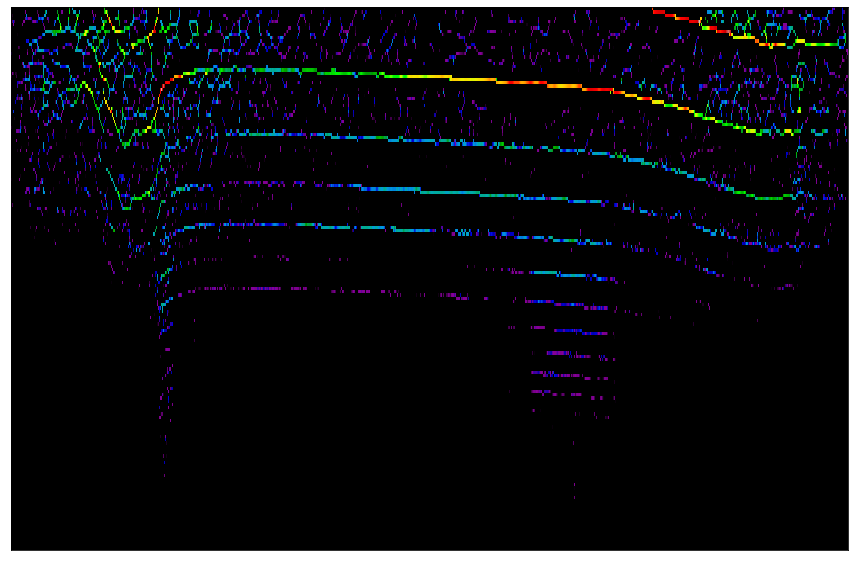

In [92]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.xticks([])
plt.yticks([])
plt.show()

In [93]:
%%time
q = 8
tdeci = 8
over = 40
noct = 96
minf = 4e-2 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

CPU times: user 5min 32s, sys: 304 ms, total: 5min 33s
Wall time: 5min 34s


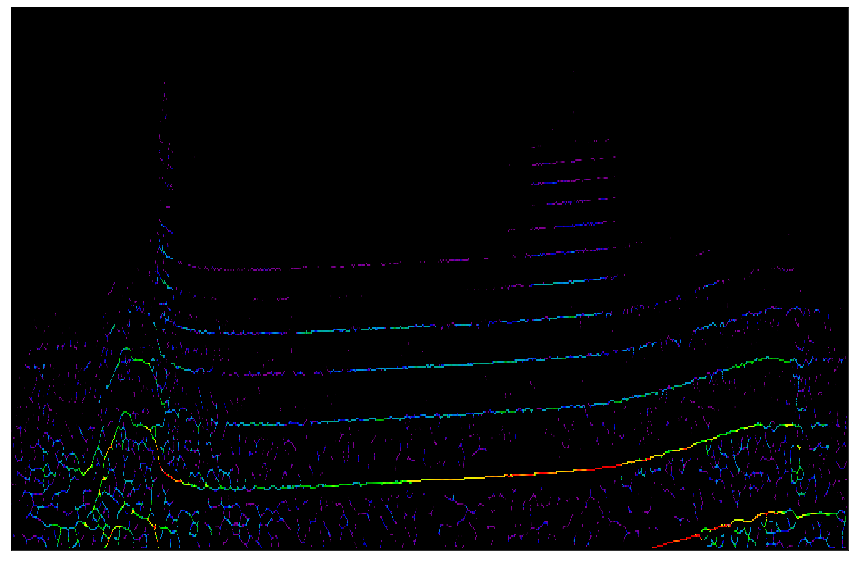

In [94]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.show()

In [95]:
%%time
q = 8
tdeci = 4
over = 80
noct = 96
minf = 4e-2 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

CPU times: user 11min 10s, sys: 492 ms, total: 11min 11s
Wall time: 11min 12s


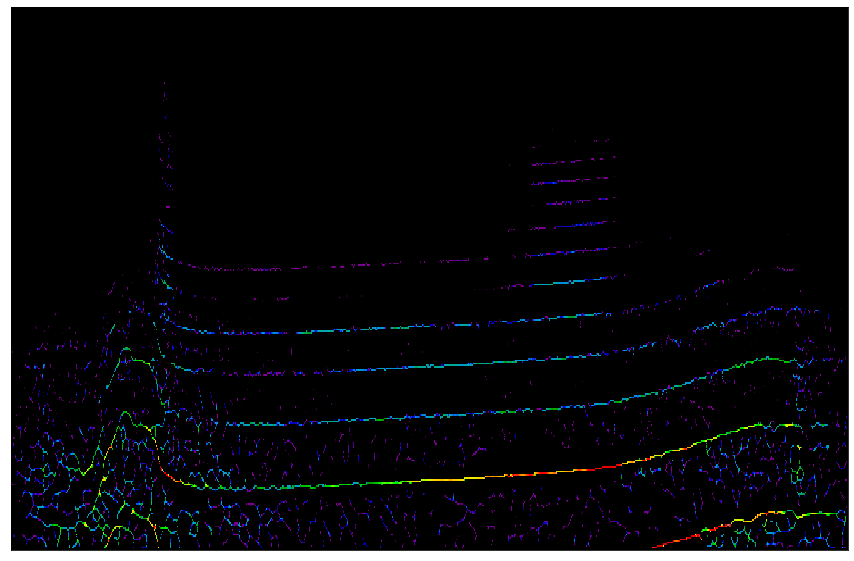

In [96]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='nipy_spectral')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.show()

# DRAFT

In [97]:
file = 'data/WatkinsPMacro.wav'
wf, sr = sf.read(file)
signal = wf[25000:45000]
time = np.linspace(0,len(signal)/sr,len(signal))

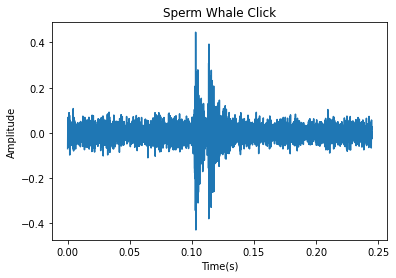

In [98]:
plt.plot(time, signal)
plt.title('Sperm Whale Click')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.show()

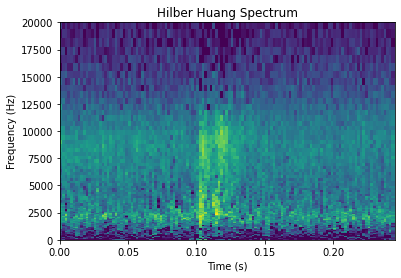

In [99]:
def hht(s, t, fs, t_res=128, f_res=256, ylim=20000):
    N = len(t)
    Ts = 1 / fs

    emd = EMD()
    imfs = emd(s)
    K = imfs.shape[0]

    t_bins = np.linspace(0, np.max(t), t_res)
    t_dig = np.digitize(t, t_bins)-1

    f_bins = np.linspace(0, 16, f_res)
    f_bins = 2**f_bins
    
    HS = np.zeros((t_res, f_res))
    for i in range(K):
        x = imfs[i, :]

        H = hilbert(x)
        H_imag = H.imag
        H_amp = np.abs(H)

        dH_imag = np.diff(H_imag)
        dH_imag = np.insert(dH_imag, len(dH_imag), dH_imag[-1])

        dx = np.diff(x)
        dx = np.insert(dx, len(dx), dx[-1])

        w = (x*dH_imag - H_imag*dx) / (H_amp**2)
        freq = w*fs / (2*np.pi)

        f_dig = np.digitize(freq, f_bins)

        for idx in range(N):
            if f_dig[idx] < f_res:
                HS[t_dig[idx], f_dig[idx]] += H_amp[idx]

    HS_dB = 20*np.log10(HS + 1e-2)

    tt, ff = np.meshgrid(t_bins, f_bins)
    fig = plt.figure()
    plt.pcolormesh(tt, ff, HS_dB.T)
    plt.ylim([0, ylim])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Hilber Huang Spectrum')
    plt.show()
    return tt, ff, HS_dB

t, f, hs_db = hht(signal, time, sr)

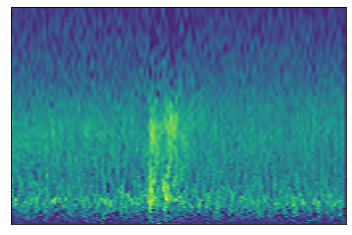

In [100]:
def interp(ts, fs, hilbert_spec, n_points=1000, ylim=20000):
    f = interpolate.RectBivariateSpline(ts, fs, hilbert_spec)

    t_interp = np.linspace(0, ts[-1], n_points)
    f_interp = np.linspace(0, fs[-1], n_points)

    hs_interp = f(t_interp, f_interp)

    tt, ff = np.meshgrid(t_interp, f_interp)
    fig = plt.figure()
    plt.pcolormesh(tt, ff, hs_interp.T)
    plt.ylim([0, ylim])
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return tt, ff, hs_interp

t, f, hs_interp = interp(t[0, :], f[:, 0], hs_db)

In [101]:
def rep_goodness(rep, n_pca=150, th=0.95, vis=True):
    pca = PCA(n_components=n_pca)
    pca.fit(rep)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

rep_goodness(hs_interp)

Number of Features to Exceed Threshold th=0.95: 51


51

In [102]:
def interp(spec, freqs, ts):
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(spec), kind='cubic')
    
    ts_interp = np.linspace(t.min(), t.max(), 1000)
    freqs_interp = np.linspace(f.min(), 20000, 1000)
    spec_interp = interp_fx(ts_interp, freqs_interp)
    
    return spec_interp, freqs_interp, ts_interp

In [103]:
f, t, Sxx = spectrogram(signal, fs=sr, window='hann', nperseg=256, noverlap=256//2, detrend=False,
                            scaling='spectrum')
Sxx, f, t = interp(Sxx, t, f)
print(f.max())
plt.pcolormesh(t, f, Sxx)

rep_goodness(Sxx)


TypeError: 'Tensor' object is not callable

In [ ]:
from PyEMD import EMD

In [ ]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)
t = np.linspace(0, len(data)/sample_rate, len(data))

In [ ]:
emd = EMD()
IMFs = emd(data)

In [ ]:
nIMFs=IMFs.shape[0]

In [ ]:
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, data, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, IMFs[n], 'g')
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

In [ ]:
from scipy.signal import hilbert
def instant_phase(imfs):
    """Extract analytical signal through Hilbert Transform."""
    analytic_signal = hilbert(imfs)  # Apply Hilbert transform to each row
    phase = np.unwrap(np.angle(analytic_signal))  # Compute angle between img and real
    return phase

In [ ]:
dt = t[1] - t[0]
instant_phases = instant_phase(IMFs)
instant_freqs = np.diff(instant_phases)/(2*np.pi*dt)

In [ ]:
fig, axes = plt.subplots(3, figsize=(12,12))

# The top panel shows the input signal
ax = axes[0]
ax.plot(t, data)
ax.set_ylabel("Amplitude [arb. u.]")
ax.set_title("Input signal")

# The middle panel shows all IMFs
ax = axes[1]
for num, imf in enumerate(IMFs):
    ax.plot(t, imf, label='IMF %s' %(num+1))

# Label the figure
ax.legend()
ax.set_ylabel("Amplitude [arb. u.]")
ax.set_title("IMFs")

# The bottom panel shows all instantaneous frequencies
ax = axes[2]
for num, instant_freq in enumerate(instant_freqs):
    ax.plot(t[:-1], instant_freq, label='IMF %s'%(num+1))

# Label the figure
ax.legend()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Inst. Freq. [Hz]")
ax.set_title("Huang-Hilbert Transform")

plt.tight_layout()

In [ ]:
_, _, Sxx = scipy.signal.spectrogram(data, fs=sample_rate, window='hann', nperseg=1024, noverlap=1024//2, detrend=False,
                            scaling='spectrum')
_, _, Sxx_1 = scipy.signal.spectrogram(IMFs[0], fs=sample_rate, window='hann', nperseg=1024, noverlap=1024//2, detrend=False,
                            scaling='spectrum')
_, _, Sxx_2 = scipy.signal.spectrogram(IMFs[1], fs=sample_rate, window='hann', nperseg=1024, noverlap=1024//2, detrend=False,
                            scaling='spectrum')
_, _, Sxx_3 = scipy.signal.spectrogram(IMFs[2], fs=sample_rate, window='hann', nperseg=1024, noverlap=1024//2, detrend=False,
                            scaling='spectrum')

In [ ]:
fig = plt.figure(figsize=(10,10))
for i, rspec in enumerate([Sxx, Sxx_1, Sxx_2,
                           Sxx_3]):
    rspec = np.abs(rspec)[:128, :]
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(np.flipud(20*np.log10(rspec)), extent=[0, 1, 0, 1], cmap='magma')
    ax.tick_params(which='both', left=False, bottom=False, labelleft=False,
            labelbottom=False)
    ax.set_xlabel('time')
    ax.set_ylabel('frequency')
    if i == 0:
        ax.set_title('signal')
    else:
        ax.set_title('mode #{}'.format(i))
plt.show()

In [ ]:
K = 128

h1 = scipy.signal.hilbert(IMFs[0])
h2 = scipy.signal.hilbert(IMFs[1])

phase1 = scipy.angle(h1)
phase2 = scipy.angle(h2)
a1 = np.abs(h1)
a2 = np.abs(h2)

if1_hist, if1_edges = np.histogram(IMFs[0], bins=K)
if2_hist, if2_edges = np.histogram(IMFs[1], bins=K)

# define empty boolean (0/1) arrays to store ...
w1 = np.zeros((K, IMFs[0].shape[0]))
w2 = np.zeros((K, IMFs[1].shape[0]))

# ... presence of freq. in each range - given the histogram
for i in range(K):
    start, stop = if1_edges[i], if1_edges[i + 1]
    w1[i, np.logical_and(IMFs[0] >= start, IMFs[0] <= stop)] = 1
    start, stop = if2_edges[i], if2_edges[i + 1]
    w2[i, np.logical_and(IMFs[1] >= start, IMFs[1] <= stop)] = 1

# multiple boolean arrays with absolut values of spectrum
TFR1 = a1 * w1
TFR2 = a2 * w2

plt.figure(figsize=(10, 8))

# decent color maps: autumn_r, hot, 
plt.imshow(TFR1 + TFR2, interpolation="nearest", aspect="auto",
           cmap='magma', origin="bottomleft",
           extent=[t[0], t[-1], 0, if1_edges.max()])
plt.grid(False)

In [ ]:
h1.shape

In [ ]:
from PyEMD import EMD

def hilb(s, unwrap=False):
    """
    Performs Hilbert transformation on signal s.
    Returns amplitude and phase of signal.
    Depending on unwrap value phase can be either
    in range [-pi, pi) (unwrap=False) or
    continuous (unwrap=True).
    """
    from scipy.signal import hilbert
    H = hilbert(s)
    amp = np.abs(H)
    phase = np.arctan2(H.imag, H.real)
    if unwrap: phase = np.unwrap(phase)

    return amp, phase



def FAhilbert(imfs, dt):
    """
    Performs Hilbert transformation on imfs.
    Returns frequency and amplitude of signal.
    """
    n_imfs = imfs.shape[0]
    f = []
    a = []
    for i in range(n_imfs - 1):
        # upper, lower = pyhht.utils.get_envelops(imfs[i, :])
        inst_imf = imfs[i, :]  # /upper
        inst_amp, phase = hilb(inst_imf, unwrap=True)
        inst_freq = (2 * math.pi) / np.diff(phase)  #

        inst_freq = np.insert(inst_freq, len(inst_freq), inst_freq[-1])
        inst_amp = np.insert(inst_amp, len(inst_amp), inst_amp[-1])

        f.append(inst_freq)
        a.append(inst_amp)
    return np.asarray(f).T, np.asarray(a).T



def hht(data, time, freqsol=33, timesol=50):
    """
    hht function for the Hilbert Huang Transform spectrum

    Parameters
    ----------
    data : array-like, shape (n_samples,)
       The input signal.
    time : array-like, shape (n_samples), optional
       Time instants of the signal samples.
       (defaults to `np.arange(1, len(signal))`)
    -------
    `matplotlib.figure.Figure`
       The figure (new or existing) in which the hht spectrum is plotted.

    example:
    --------------------

    .. sourcecode:: ipython
        f = Dataset('./source/obs.nc')
        # read one example data
        fsh = f.variables['FSH']
        time = f.variables['time']
        one_site = np.ma.masked_invalid(fsh[0,:])
        time = time[~one_site.mask]
        data = one_site.compressed()
        hht(data, time)


    ----------------
        """
    #   freqsol give frequency - axis resolution for hilbert - spectrum
    #   timesol give time - axis resolution for hilbert - spectrum
    t0 = time[0]
    t1 = time[-1]
    dt = (t1 - t0) / (len(time) - 1)

    eemd = EMD()
    imfs = eemd.emd(data)
    freq, amp = FAhilbert(imfs, dt)

    #     fw0 = np.min(np.min(freq)) # maximum frequency
    #     fw1 = np.max(np.max(freq)) # maximum frequency

    #     if fw0 <= 0:
    #         fw0 = np.min(np.min(freq[freq > 0])) # only consider positive frequency

    #     fw = fw1-fw0
    tw = t1 - t0

    bins = np.linspace(0, 12, freqsol)  # np.logspace(0, 10, freqsol, base=2.0)
    p = np.digitize(freq, 2 ** bins)
    t = np.ceil((timesol - 1) * (time - t0) / tw)
    t = t.astype(int)

    hilbert_spectrum = np.zeros([timesol, freqsol])
    for i in range(len(time)):
        for j in range(imfs.shape[0] - 1):
            if p[i, j] >= 0 and p[i, j] < freqsol:
                hilbert_spectrum[t[i], p[i, j]] += amp[i, j]

    hilbert_spectrum = abs(hilbert_spectrum)
    fig1 = plt.figure(figsize=(5, 5))
    plot_imfs(data, imfs, time_samples=time, fig=fig1)

    fig2 = plt.figure(figsize=(5, 5))
    plot_frequency(data, freq.T, time_samples=time, fig=fig2)

    fig0 = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    c = ax.contourf(np.linspace(t0, t1, timesol), bins,
                    hilbert_spectrum.T)  # , colors=('whites','lategray','navy','darkgreen','gold','red')
    ax.invert_yaxis()
    ax.set_yticks(np.linspace(1, 11, 11))
    Yticks = [float(math.pow(2, p)) for p in np.linspace(1, 11, 11)]  # make 2^periods
    ax.set_yticklabels(Yticks)
    ax.set_xlabel('Time', fontsize=8)
    ax.set_ylabel('Period', fontsize=8)
    position = fig3.add_axes([0.2, -0., 0.6, 0.01])
    cbar = plt.colorbar(c, cax=position, orientation='horizontal')
    cbar.set_label('Power')
    plt.show()

In [ ]:
data, sample_rate = sf.read(path_name)
t = np.linspace(0, len(data)/sample_rate, len(data))

In [ ]:
from scipy.signal import hilbert
from PyEMD import EMD

def hilbert_amp_phase(signal):
    
    H = hilbert(signal)
    amp = np.abs(H)
    phase = np.unwrap(np.angle(H)) 

    return amp, phase

a, p = hilbert_amp_phase(data)
a.shape, p.shape

In [ ]:
def freq_amp_hilbert(imfs, dt):
    n_imfs = imfs.shape[0]
    f, a = [], []
    for i in range(n_imfs):
        inst_imf = imfs[i, :]
        inst_amp, phase = hilbert_amp_phase(inst_imf)
        inst_freq = (2 * math.pi) / np.diff(phase)
        
        inst_freq = np.insert(inst_freq, len(inst_freq), inst_freq[-1])
        inst_amp = np.insert(inst_amp, len(inst_amp), inst_amp[-1])
        
        f.append(inst_freq)
        a.append(inst_amp)
    return np.asarray(f).T, np.asarray(a).T

emd = EMD()
imfs = emd(data)
freqs, amps = freq_amp_hilbert(imfs, t[1]-t[0])
freqs.shape, amps.shape

In [ ]:
def hht_spec(sig, time, freqsol=128, timesol=128):
    dt = time[1]-time[0]
    emd = EMD()
    imfs = emd.emd(sig)
    print(imfs)
    freq, amp = freq_amp_hilbert(imfs, dt)
    
    fw0 = np.min(np.min(freq))
    fw1 = np.max(np.max(freq))

    if fw0 <= 0:
        fw0 = np.min(np.min(freq[freq > 0])) # only consider positive frequency
    
    freq[freq < 0] = 0
    fw = fw1-fw0
    tw = time[-1] - time[0]
    bins = np.linspace(0, 18, freqsol)
    p = np.digitize(freq, 2 ** bins)
    print(bins.shape)
    print(np.mean(freq))
    print(np.min(freq))
    print(np.std(freq))
    print((2**bins).max())
    print(freq.max())
    print(p.shape)
    print(p.max())
    
    t = np.ceil((timesol - 1) * (time - time[0]) / tw)
    t = t.astype(int)
    
    hilbert_spectrum = np.zeros([timesol, freqsol])

    for i in range(len(time)):
        for j in range(imfs.shape[0]):
            if p[i, j] >= 0 and p[i, j] < freqsol:
                hilbert_spectrum[t[i], p[i, j]] += np.abs(20*np.log(amp[i, j]+1e-13))
    
    hilbert_spectrum[hilbert_spectrum > 25000] = 25000
                
    fig0 = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    c = ax.contourf(np.linspace(time[0], time[-1], timesol), bins,
                    hilbert_spectrum.T)
    ax.set_yticks(np.linspace(1, 17, 17))
    Yticks = [int(math.pow(2, p)) for p in np.linspace(1, 17, 17)]
    ax.set_yticklabels(Yticks)
    ax.set_xlabel('Time', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    plt.show()
hht_spec(data, t)

In [ ]:
x = annos_df.iloc[2]
wf, sr = extract_click(x)
t = np.arange(0, len(wf[:,0])) / sr

In [ ]:
hht_spec(wf[:,0], t, freqsol=128, timesol=256)

### Spectral Hyperresolution Representation

In [ ]:
!pip install git+git://github.com/earthspecies/spectral_hyperresolution.git

In [ ]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data, sample_rate = sf.read(path_name)

In [ ]:
from spectral_hyperresolution.linear_reassignment import high_resolution_spectrogram
data_2 = data.reshape(data.shape[0], 1)

q = 2
tdeci = 225
over = 20
noct = 24
minf = 4e-3
maxf = 0.45
spectrogram = high_resolution_spectrogram(data_2, q, tdeci, over, noct, minf, maxf)

In [ ]:
fig = plt.figure(figsize = (15,10))
librosa.display.specshow(librosa.core.amplitude_to_db(spectrogram.T), cmap='magma')
plt.xticks([])
plt.yticks([])
plt.show()